# Maximum Likelihood Estimation (MLE) and Maximum a Posteriori (MAP)

In [930]:
import numpy as np
import math
import matplotlib.pyplot as plt

# 1)  Define a test problem in the following way:

## 1.1) Let the user fix a positive integer $K>0$, and define $\theta_{true}=(1,1,...,1)^T$

In [931]:
# For user input 
# K = -1
# while K < 0:
#     K = int(input()) # 4
    
# For debug
K=4

theta_true = np.ones((K, 1))

# 1.2) Define an input dataset $X=[x^1x^2...x^N] \in \R^N$, where $x^i$ are $N$ uniformly distributed datapoints in the interval $[a,b]$, where $a< b$ are values that the user can select.

In [932]:
# For user input 
# a, b = [float(x) for x in input().split()] # [-7, 7]

# For debug
a,b = [-7,7]
N = 100
np.random.seed(42)
X = np.random.uniform(a, b, (1, N))
print(X.shape)

(1, 100)


## 1.3) Given a set of functions $\{\phi_1, \phi_2,...,\phi_K\}$, define the Generalized Vandermonde matrix $\Phi(X) \in \R^{N \times K}$, whose element in position $i,j$ is $\phi_j(x^i)$. In particular, write a function defining the classical Vandermonde matrix where $\phi_j(x)=x^{j-1}$

In [933]:
def Vandermonde(X, K):
    N = X.shape[-1]
    Phi  = np.zeros((N, K))
    for k in range(K):
        Phi[:, k] = X**k
    return Phi

In [934]:
Phi = Vandermonde(X, K)
print(Phi.shape)

(100, 4)


## 1.4) Given a variance $\sigma^2>0$ defined by the user, compute $Y=\Phi(X)\theta_{true}+e$, where $e ~ \mathcal{N} (0, \sigma^2 I)$ is Gaussian distributed noise with variance $\sigma^2$. Try the following experiments for different values of $\sigma^2$. 
Note that the test problem defined in this way is very similar to what we did to define a test problem in the first Lab.

(100, 1)


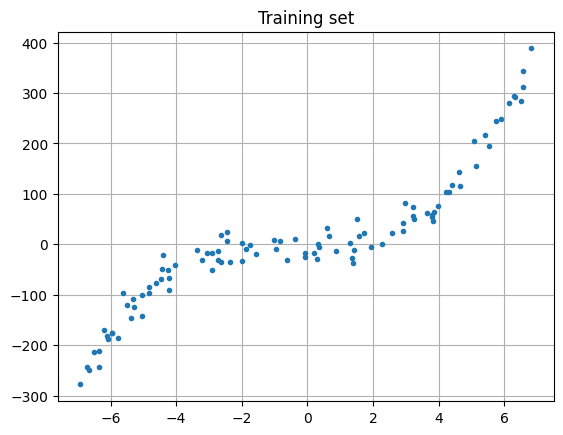

In [935]:
# For input user
# sigma_squared = float(input()) #500

# For debug
sigma_squared = 500
e = np.random.normal(0, math.sqrt(sigma_squared), (N, 1))
Y = Phi @ theta_true + e
print(Y.shape)
plt.plot(X.T, Y, '.')
plt.grid()
plt.title('Training set')
plt.show()

# 2) We now built a dataset $\mathbb{D}=\{X,Y\}$ such that $\theta_{true}=(1,1,...,1)^T \in \R^K$ is the best solution to the least squares problem $\Phi(X)\theta \approx Y$

In [936]:
D = (X,Y)

# 3) Pretend not to know the correct value of $K$. The first task is to try to guess it and use it to approximate the true solution $\theta_{true}$ by MLE and MAP.

## 3.1) Write a function that takes as input the training data $\mathbb{D} = (X, Y )$ and K and returns the MLE solution (with Gaussian assumption) $\theta_{MLE} ∈ \R^K$ for that problem
Note that the loss function can be optimized by GD, SGD or Normal Equations.

In [937]:
# We start from the loss function to be optimized
def loss(Phi, theta, Y):
    return 1/2 * (np.linalg.norm(Phi @ theta - Y))**2

def grad_loss(Phi, theta, Y):
    return Phi.T @ (Phi @ theta - Y)

## 3.1.1) Gradient Descent optimization

In [938]:
# Then we use the optimization functions
def backtracking(f, grad_f, x, Phi, Y):
    alpha = 1
    c = 1e-4
    tau = 0.25
    
    while np.linalg.norm(f(Phi, x - alpha * grad_f(Phi, x, Y), Y)) > np.linalg.norm(f(Phi, x, Y) - (c * alpha * np.linalg.norm(grad_f(Phi, x, Y), 2)) ** 2):
        alpha = tau * alpha
    return alpha

def GD(f, grad_f, Phi, Y, theta_0, kmax, tol_x, tol_f, alpha=0):
    theta = []
    backtrack = alpha == 0
    theta_old = theta_0
    k = 0
    condition = True
    while condition:
        theta.append(theta_old)
        if backtrack:
            alpha = backtracking(f, grad_f, theta_old, Phi, Y)
        theta_k = theta_old - alpha * grad_f(Phi, theta_old, Y)
        condition1 = np.linalg.norm(grad_f(Phi, theta_old, Y), 2) > tol_f * np.linalg.norm(grad_f(Phi, theta_old, Y), 2)
        condition2 = np.linalg.norm(theta_k - theta_old, 2) > tol_x
        condition3 = k < kmax
        condition = condition1 & condition2 & condition3
        k += 1
        theta_old = theta_k
    return np.array(theta)

def MLE_gd(D, K):
    X, Y = D
    Phi = Vandermonde(X, K)
    theta_0 = np.zeros((K, 1))
    theta = GD(loss, grad_loss, Phi, Y, theta_0, 100, 1e-15, 1e-15)
    return theta[-1]

## 3.1.2) Stochastic gradient descent optimiaztion

In [939]:
def SGD(grad_loss, W0, K, D, batch_size, n_epochs, learning_rate, verbose=True):
    # Extracting X, Y from D
    X, y = D
    # Save in memory the length of x (and y)
    d, N = X.shape
    # Compute the number of batches per epoch
    n_batch_per_epoch = N // batch_size

    # Initialize all variables to return
    w = []

    # Initialize parameter w_k
    w_k = W0
    w.append(w_k.copy())
    # print(f"We start from {w_k}")

    # Iterate over the epochs
    for epoch in range(n_epochs):
        idx = np.arange(N)
        np.random.shuffle(idx)
        for k in range(n_batch_per_epoch):
            # Extract mini-batch
            id = idx[k * batch_size: (k + 1) * batch_size]
            x_temp = X[:, id]
            y_temp = y[id, :]

            B = (x_temp, y_temp)
            Phi = Vandermonde(x_temp, K)

            # Gradient descent update
            grad = grad_loss(Phi, w_k, y_temp)
            clip_threshold = 1e3
            grad = np.clip(grad, -clip_threshold, clip_threshold)
            if verbose: print("Gradient shape:", grad.shape)
            if verbose: print("Gradient:", grad)
            # print(f"We subtract {learning_rate * grad}")
            w_k = w_k - learning_rate * grad
            # print(f"Now we have {w_k}")
            w.append(w_k.copy())
            # print(f"We collected {w}")

            # Compute and print loss
            loss_value = loss(Phi, w_k, y_temp)
            if verbose: print("Loss:", loss_value)

    return np.array(w)

def MLE_sgd(D, K, verbose):
    theta_0 = np.zeros((K, 1))
    theta = SGD(grad_loss, theta_0, K, D, 64, 300, 1e-8, verbose)
    return theta[-1]


## 3.1.3) Normal equations optimization

In [940]:
def MLENormalEquations(Phi, Y):
    return np.linalg.inv((Phi.T @ Phi)) @ Phi.T @ Y
    # return np.linalg.solve((Phi.T @ Phi), Phi.T @ Y)

def MLE_ne(D, K):
    X, Y = D
    Phi = Vandermonde(X, K)
    return MLENormalEquations(Phi, Y)

In [941]:
# In order to generalize the choice of the optimiation
modes = [
            'Gradient Descent',
            'Normal Equations',
            'Stochastic Gradient Descent',
        ]
def MLE(D, K, mode, verbose=False):
    match mode:
        case 'Gradient Descent' : return MLE_gd(D, K)
        case 'Normal Equations' : return MLE_ne(D, K)
        case 'Stochastic Gradient Descent' : return MLE_sgd(D, K, verbose)

## 3.2) Write a function that takes as input a set of $K$-dimensional parameter vector $\theta$ and a test set $\mathcal{T E} = \{X_{test}, Y_{test}\}$ and returns the average absolute error of the polynomial regressor $f_\theta (x)$ over $X_{test}$, computed as: $$ \frac{1}{N_{test}} \| f_\theta(X_{test}) - Y_{test} \|_2^2 $$

In [942]:
def f_theta(X, theta):
    Phi = Vandermonde(X, theta.shape[0]) #theta.shape = (Kx1)
    return Phi @ theta

def avg_absolute_error(theta, test_set):
    X_test, Y_test = test_set
    N_test = X_test.shape[1]
    return 1 / N_test * (np.linalg.norm(f_theta(X_test, theta) - Y_test, 2))**2

In [943]:
X_train, Y_train = X,Y
X_test = np.random.uniform(a, b, (1, round(N / 3)))
e = np.random.normal(0, math.sqrt(sigma_squared), (round(N / 3), 1))
Phi_test = Vandermonde(X_test, K)
Y_test = Phi_test @ theta_true + e

## 3.3) For different values of $K$, plot the training datapoints and the test datapoints with different colors and visualize (as a continuous line) the learnt regression model $f_{\theta_{MLE}}(x)$. Comment the results.

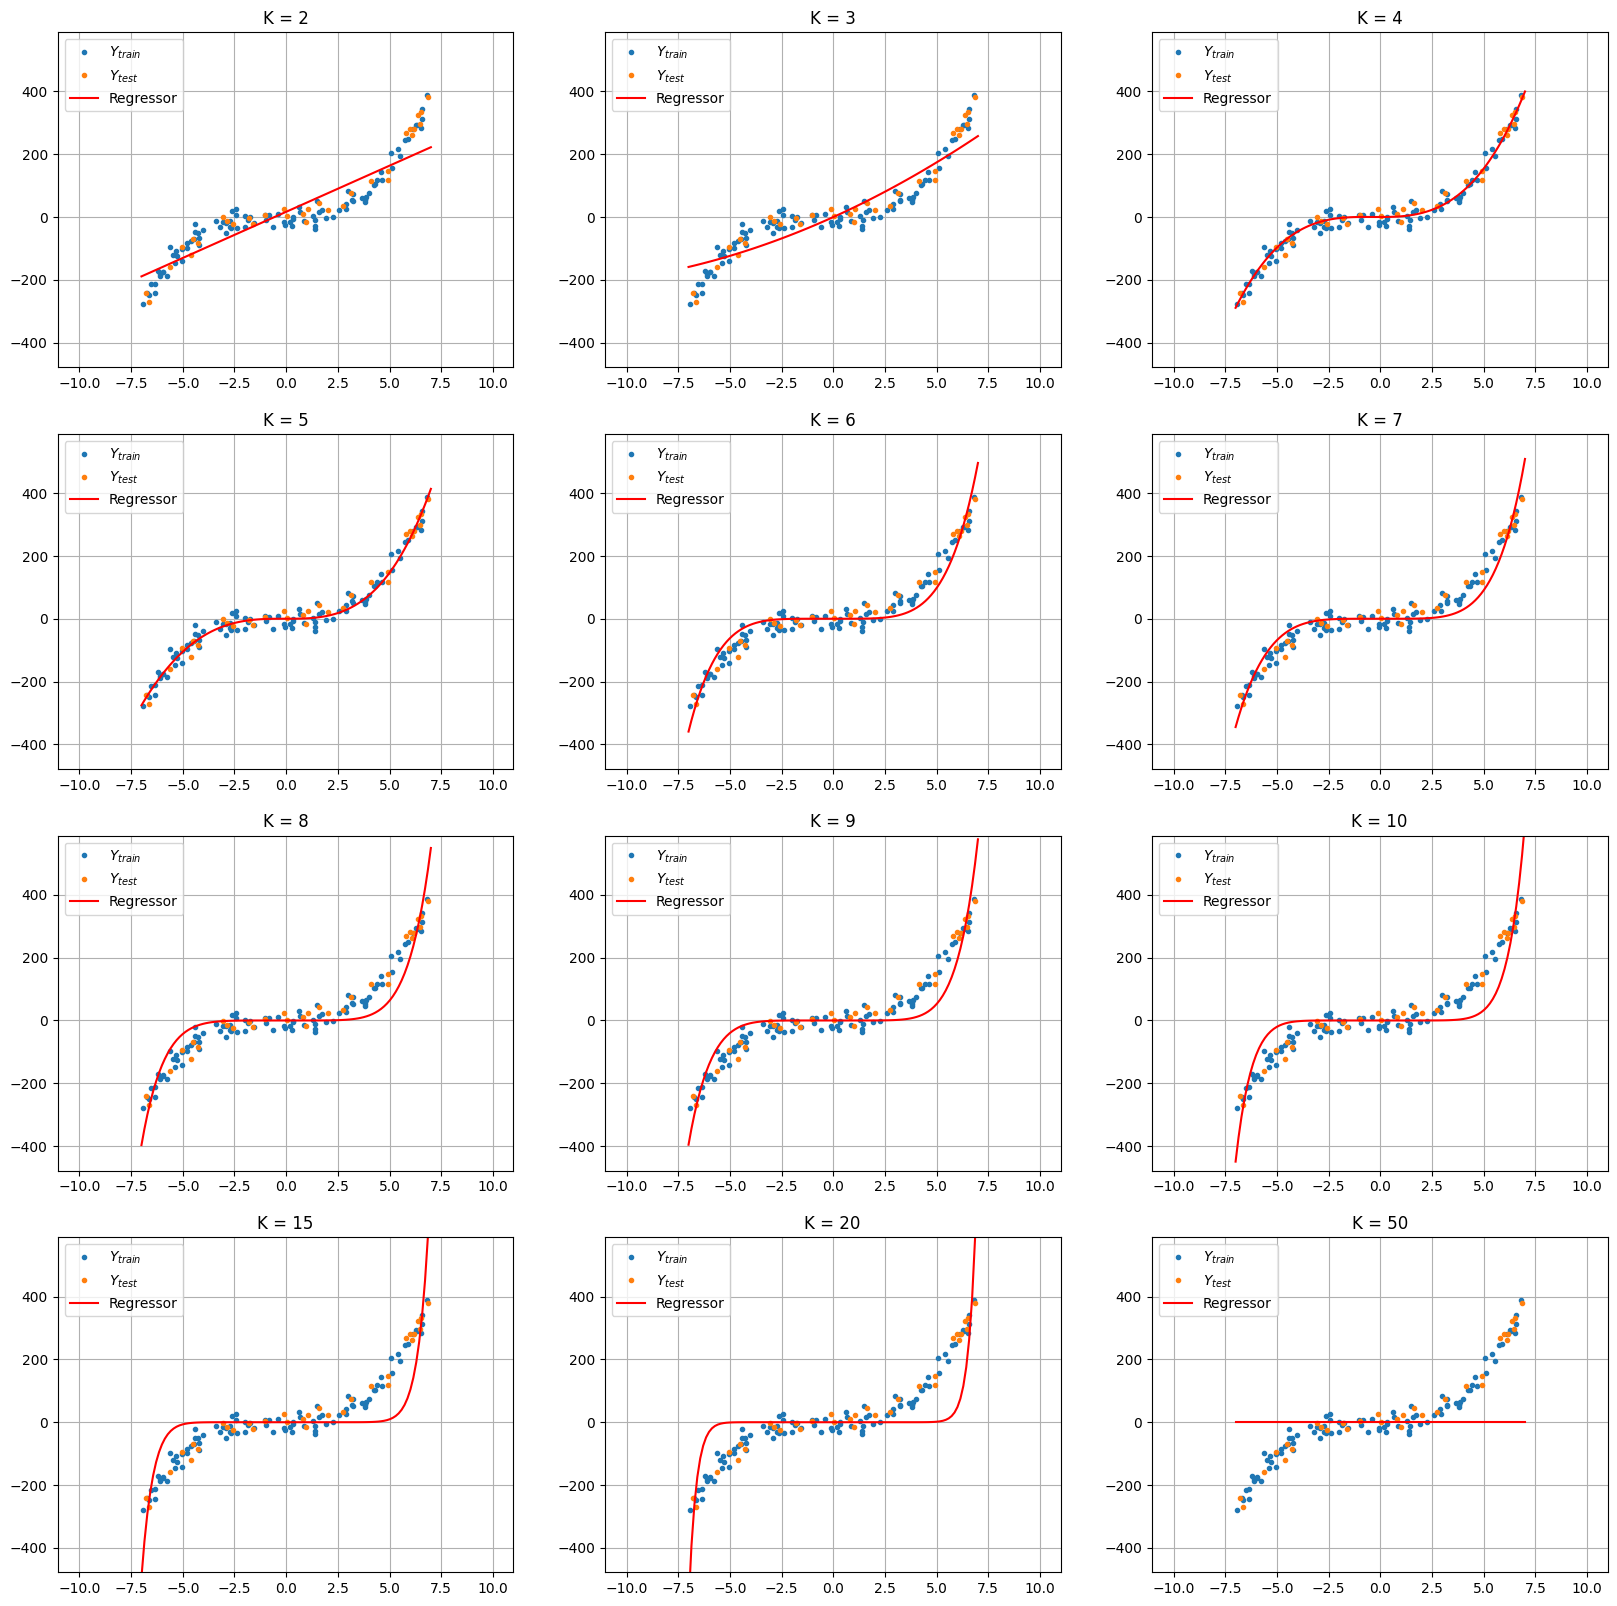

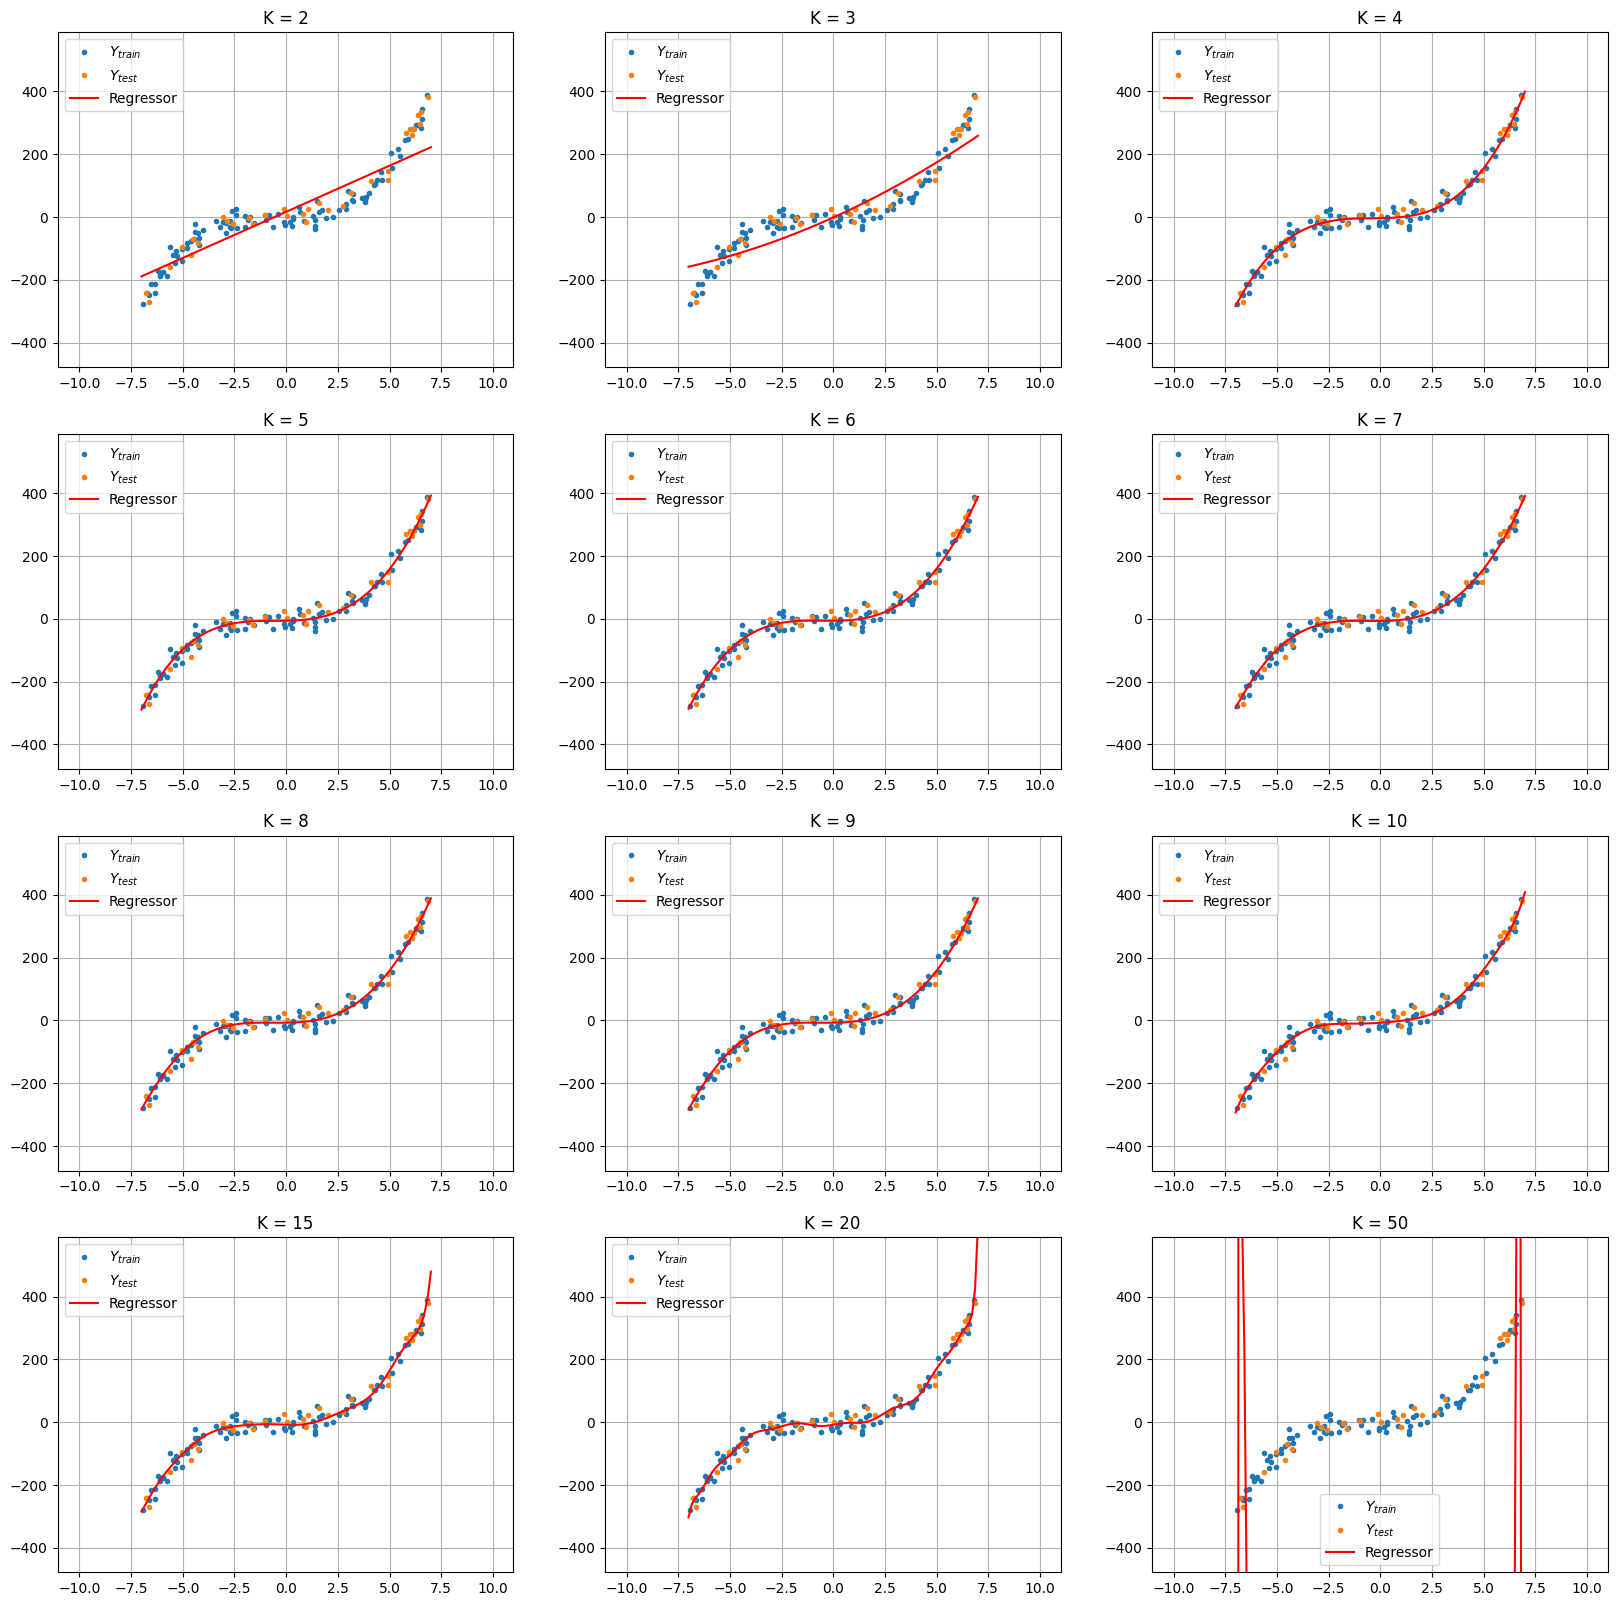

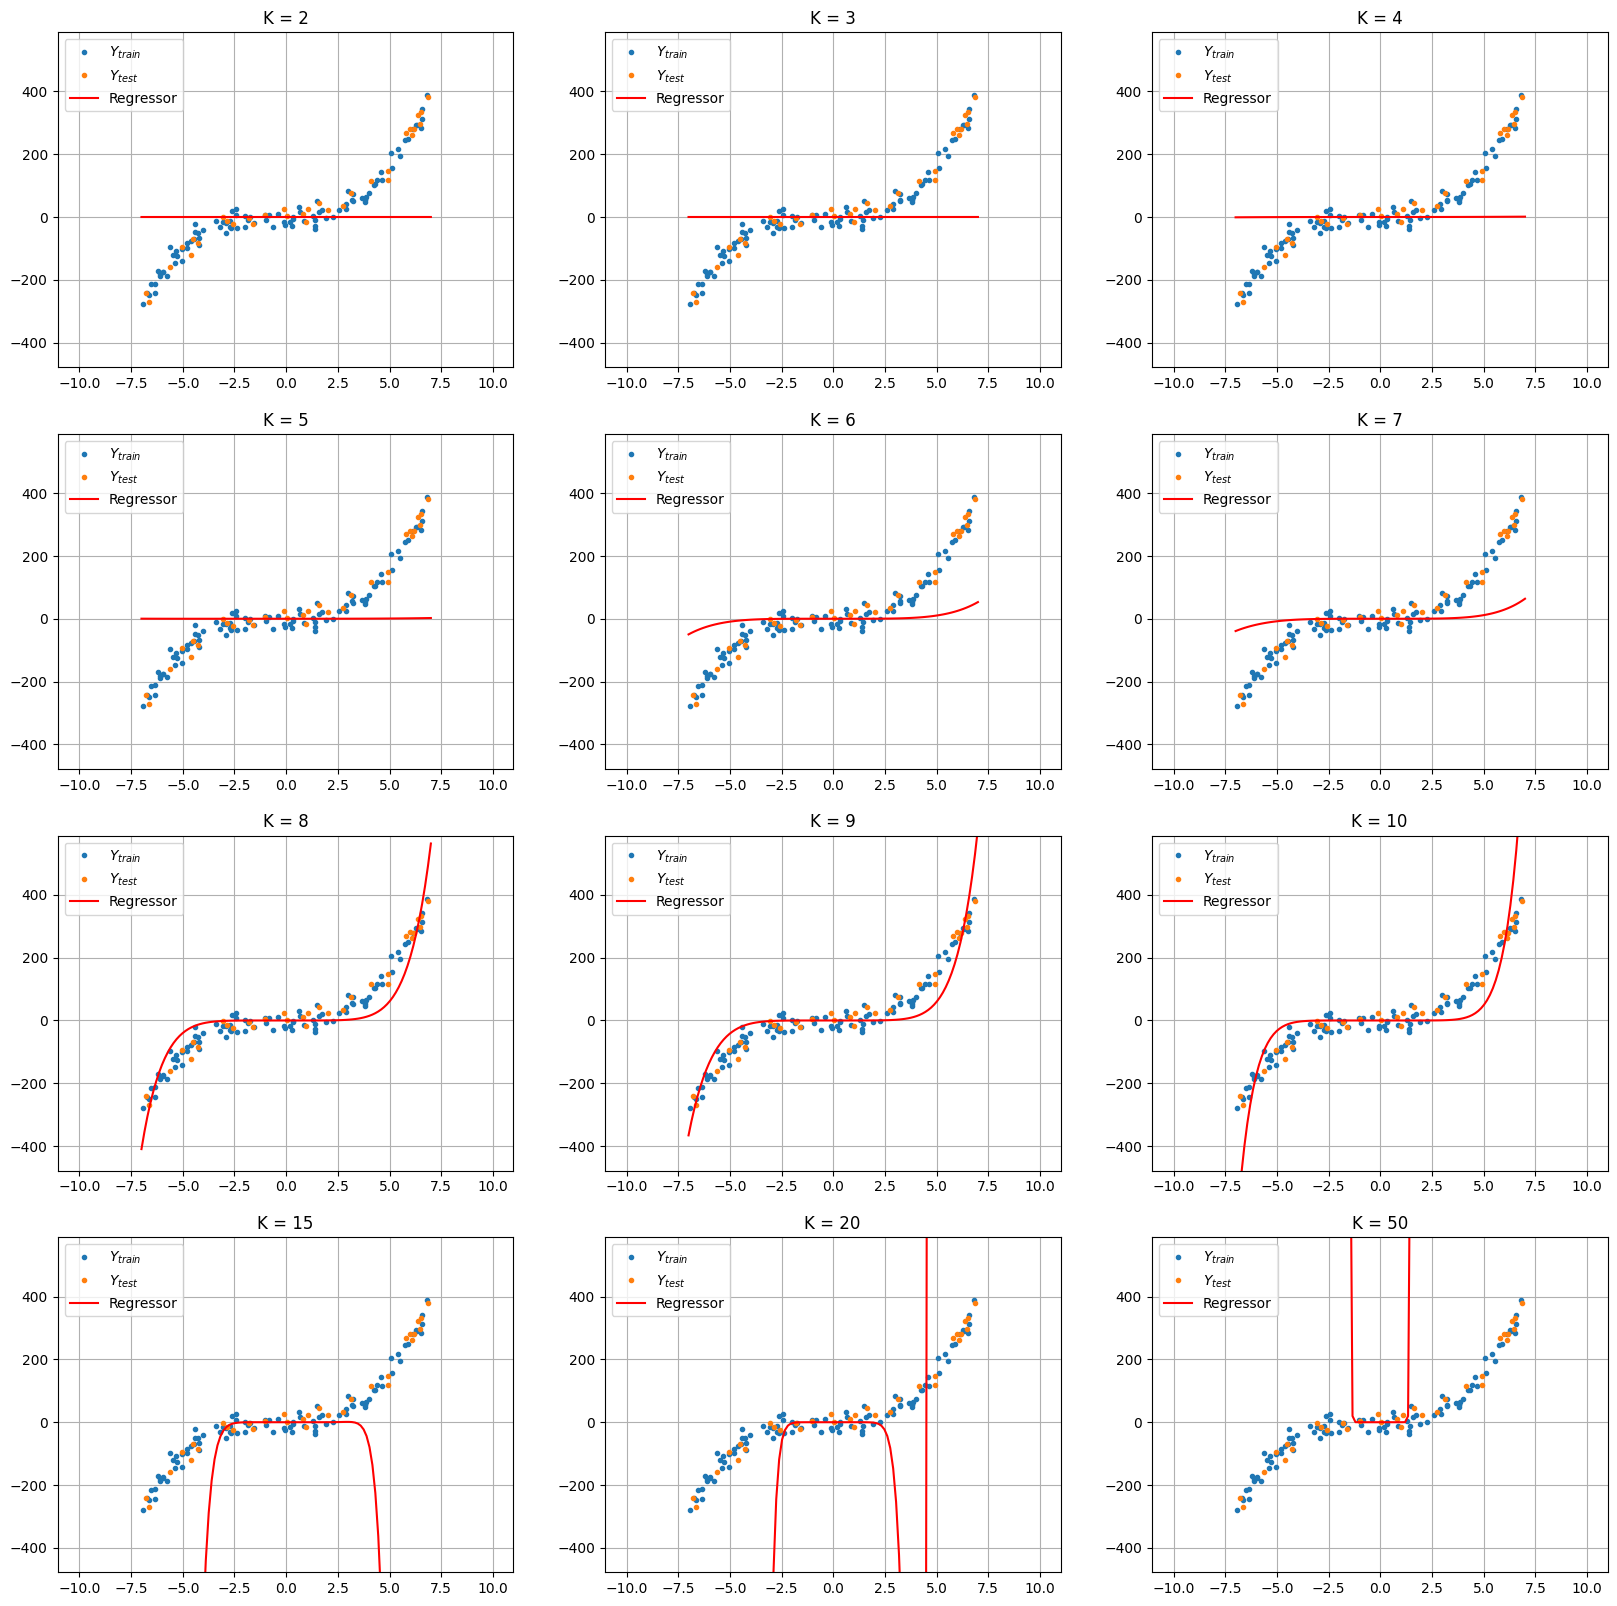

In [944]:
from IPython.display import HTML

Ks = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 50]
margin = 30  # percentuale di margine aggiunto

for mode_name in modes: 
    display(HTML("<center> <h2>Optimization by " + mode_name + "</h2></center>"))
    plt.figure(figsize=(20,20))

    # Determina i limiti comuni per tutti i subplot
    y_min = min(Y_train.min(), Y_test.min())
    y_max = max(Y_train.max(), Y_test.max())
    x_min = min(X_train.min(), X_test.min())
    x_max = max(X_train.max(), X_test.max())
    
    # Calcola i margini
    y_range = y_max - y_min
    x_range = x_max - x_min
    
    y_margin = y_range * (margin / 100)
    x_margin = x_range * (margin / 100)
    
    y_min -= y_margin
    y_max += y_margin
    x_min -= x_margin
    x_max += x_margin

    for j, k in enumerate(Ks, 1):
        theta_NE = MLE((X_train, Y_train), k, mode=mode_name, verbose=False)
        regressor = f_theta(np.linspace(a, b, num=100), theta_NE)
        
        plt.subplot(4, 3, j)
        plt.plot(X_train.T, Y_train, '.')
        plt.plot(X_test.T, Y_test, '.')
        plt.plot(np.linspace(a, b, num=100), regressor, 'r')
        plt.title(f"K = {k}")
        plt.grid()
        plt.legend([r'$Y_{train}$', r'$Y_{test}$', 'Regressor'])
        
        # Imposta i limiti degli assi con i margini
        plt.ylim([y_min, y_max])
        plt.xlim([x_min, x_max])

    plt.show()

## 3.4) For increasing values of $K$, use the functions defined above to compute the training and test error, where the test set is generated by sampling $N_{test}$ new points on the same interval $[a, b]$ of the training set and generating the corresponding $Y_{test}$ with the same procedure of the training set. Plot the two errors with respect to $K$. Comment the results.

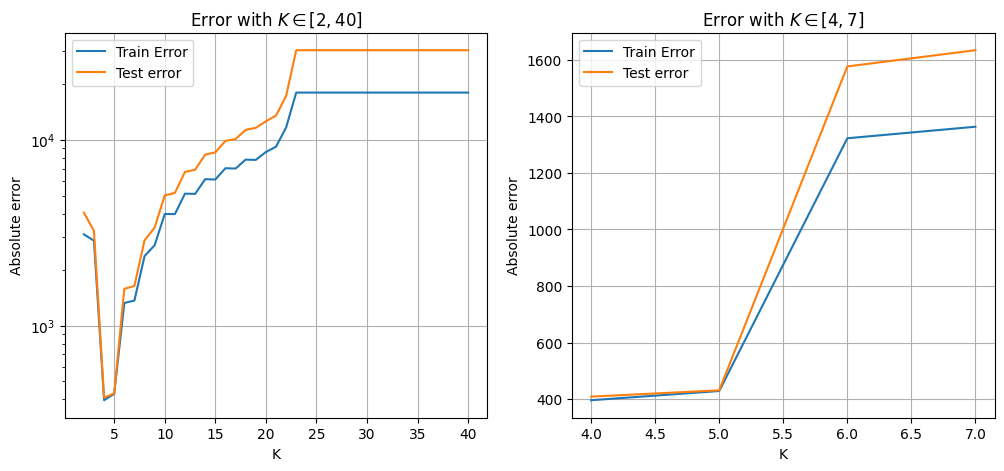

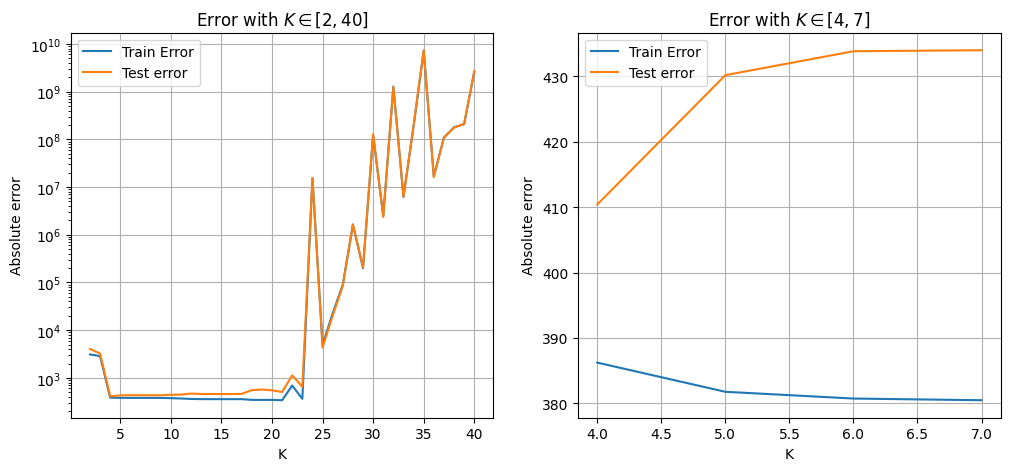

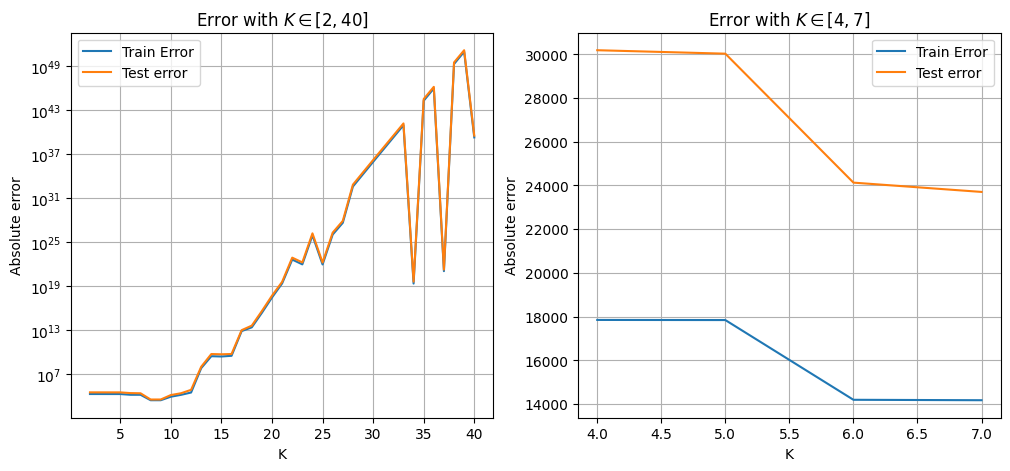

In [945]:
for mode_name in modes : 
    display(HTML("<center> <h2>Optimization by " + mode_name + "</h2></center>"))

    Ks = np.arange(start=2, stop=41, step=1)
    train_err = []
    test_err = []

    for k in Ks:
        Phi_k = Vandermonde(X_train, k)
        theta_NE = MLE((X_train, Y_train), k, mode=mode_name)

        train_err.append(avg_absolute_error(theta_NE, (X_train, Y_train)))
        test_err.append(avg_absolute_error(theta_NE, (X_test, Y_test)))

    plt.figure(figsize=(12, 5))

    plt.subplot(121)
    plt.plot(Ks, train_err)
    plt.plot(Ks, test_err)
    plt.grid()
    plt.yscale('log')
    plt.legend(['Train Error', 'Test error'])
    plt.xlabel('K')
    plt.title(rf'Error with $K \in [2,{k}]$')
    plt.ylabel('Absolute error')

    Ks = np.arange(start=K, stop=8, step=1)
    train_err = []
    test_err = []

    for k in Ks:
        Phi_k = Vandermonde(X_train, k)
        theta_NE = MLE((X_train, Y_train), k, mode=mode_name)

        train_err.append(avg_absolute_error(theta_NE, (X_train, Y_train)))
        test_err.append(avg_absolute_error(theta_NE, (X_test, Y_test)))

    plt.subplot(122)
    plt.plot(Ks, train_err)
    plt.plot(Ks, test_err)
    plt.grid()
    plt.legend(['Train Error', 'Test error'])
    plt.xlabel('K')
    plt.title(rf'Error with $K \in [{K},{k}]$')
    plt.ylabel('Absolute error')
    plt.show()


## 3.5) Write a function that takes as input the training data $\mathbb{D} = (X, Y ), K, λ > 0$ and returns the MAP solution (with Gaussian assumption) $θ_{MAP} ∈ \R^K$ for that problem.
Note that the loss function can be optimized by GD, SGD, or Normal Equations.

In [946]:
# We start from the loss function to be optimized
def loss_MAP(Phi, theta, Y, lmbda):
    return 1/2 * (Phi @ theta - Y) + 1/2 * lmbda *(np.linalg.norm(theta))**2
def grad_loss_MAP(Phi, theta, Y, lmbda):
    return Phi.T @ (Phi @ theta - Y) + lmbda * theta

### 3.5.1) Gradient Descent optimization

In [947]:
def backtracking_MAP(f, grad_f, x,  Phi, Y, lmbda):
    alpha = 1
    c = 1e-4
    tau = 0.25
    
    while np.linalg.norm(f(Phi, x - alpha * grad_f(Phi, x, Y, lmbda), Y, lmbda)) > np.linalg.norm(f(Phi, x, Y, lmbda) - (c * alpha * np.linalg.norm(grad_f(Phi, x, Y, lmbda), 2)) ** 2):
        alpha = tau * alpha
        
        # if alpha < 1e-15:
        #     break
    return alpha

def GD_MAP(f, grad_f, Phi, Y, theta_0, lmbda, kmax, tol_x, tol_f, alpha=0):
    theta = []
    backtrack = alpha == 0
    theta_old = theta_0
    k = 0
    condition = True
    while condition:
        theta.append(theta_old)
        if backtrack:
            alpha = backtracking_MAP(f, grad_f, theta_old, Phi, Y, lmbda)
        theta_k = theta_old - alpha * grad_f(Phi, theta_old, Y, lmbda)
        condition1 = np.linalg.norm(grad_f(Phi, theta_old, Y, lmbda), 2) > tol_f * np.linalg.norm(grad_f(Phi, theta_old, Y, lmbda), 2)
        condition2 =  np.linalg.norm(theta_k - theta_old, 2) > tol_x
        condition3 = k < kmax
        condition =  condition1 & condition2 & condition3
        k += 1
        theta_old = theta_k
    return np.array(theta)

def MAP_gd(D, K, lmbda):
    X, Y = D
    Phi = Vandermonde(X, K)
    theta_0 = np.zeros((K, 1))
    theta = GD_MAP(loss_MAP, grad_loss_MAP, Phi, Y, theta_0, lmbda, 100, 1e-5, 1e-5)
    return theta[-1]

### 3.5.2) Normal Equations optimization

In [948]:
def MAP_normal_equations(Phi, lmbda, Y):
    return np.linalg.inv(Phi.T @ Phi - lmbda * np.identity(Phi.shape[1])) @ Phi.T @ Y
    # return np.linalg.solve(Phi.T @ Phi - lmbda * np.identity(Phi.shape[1]), Phi.T @ Y)

def MAP_ne(D, K, lmbda):
    X, Y = D
    Phi = Vandermonde(X, K)
    return MAP_normal_equations(Phi, lmbda, Y)

### 3.5.1) Stochastic Gradient Descent optimization

In [949]:
def SGD_MAP(grad_loss_MAP, W0, K, D, lmbda, batch_size, n_epochs, learning_rate, verbose=True):
    # Extracting X, Y from D
    X, y = D
    # Save in memory the length of X (and y)
    d, N = X.shape
    # Compute the number of batches per epoch
    n_batch_per_epoch = N // batch_size

    # Initialize all variables to return
    w = []

    # Initialize parameter w_k
    w_k = W0
    w.append(w_k.copy())

    # Iterate over the epochs
    for epoch in range(n_epochs):
        idx = np.arange(N)
        np.random.shuffle(idx)
        for k in range(n_batch_per_epoch):
            # Extract mini-batch
            id = idx[k * batch_size: (k + 1) * batch_size]
            x_temp = X[:, id]
            y_temp = y[id, :]

            B = (x_temp, y_temp)
            Phi = Vandermonde(x_temp, K)

            # Gradient descent update
            grad = grad_loss_MAP(Phi, w_k, y_temp, lmbda)
            clip_threshold = 1e3
            grad = np.clip(grad, -clip_threshold, clip_threshold)
            if verbose: print("Gradient shape:", grad.shape)
            if verbose: print("Gradient:", grad)
            w_k = w_k - learning_rate * grad
            w.append(w_k.copy())

            # Compute and print loss
            loss_value = loss_MAP(Phi, w_k, y_temp, lmbda)
            if verbose: print("Loss:", loss_value)

    return np.array(w)

def MAP_sgd(D, K, lmbda, verbose):
    theta_0 = np.zeros((K, 1))
    theta = SGD_MAP(grad_loss_MAP, theta_0, K, D, lmbda, 64, 300, 1e-8, verbose)
    return theta[-1]


In [950]:
def MAP(D, K, lmbda, mode, verbose=False):
    match mode:
        case 'Gradient Descent' : return MAP_gd(D, K, lmbda)
        case 'Normal Equations' : return MAP_ne(D, K, lmbda)
        case 'Stochastic Gradient Descent' : return MAP_sgd(D, K, lmbda, verbose)

## 3.6) For $K$ lower, equal and greater than the correct degree of the test polynomial, plot the training datapoints and the test datapoints with different colors, and visualize (as a continuous line) the learnt regression model $f_{θ_{M AP}} (x)$ with different values of $λ$

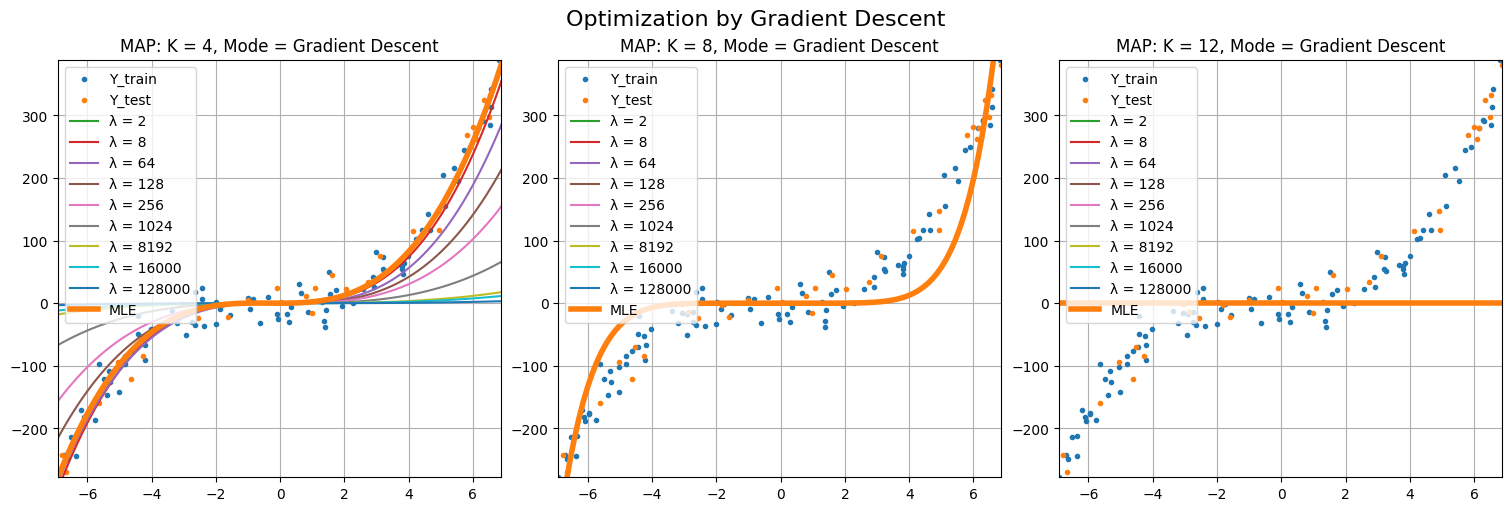

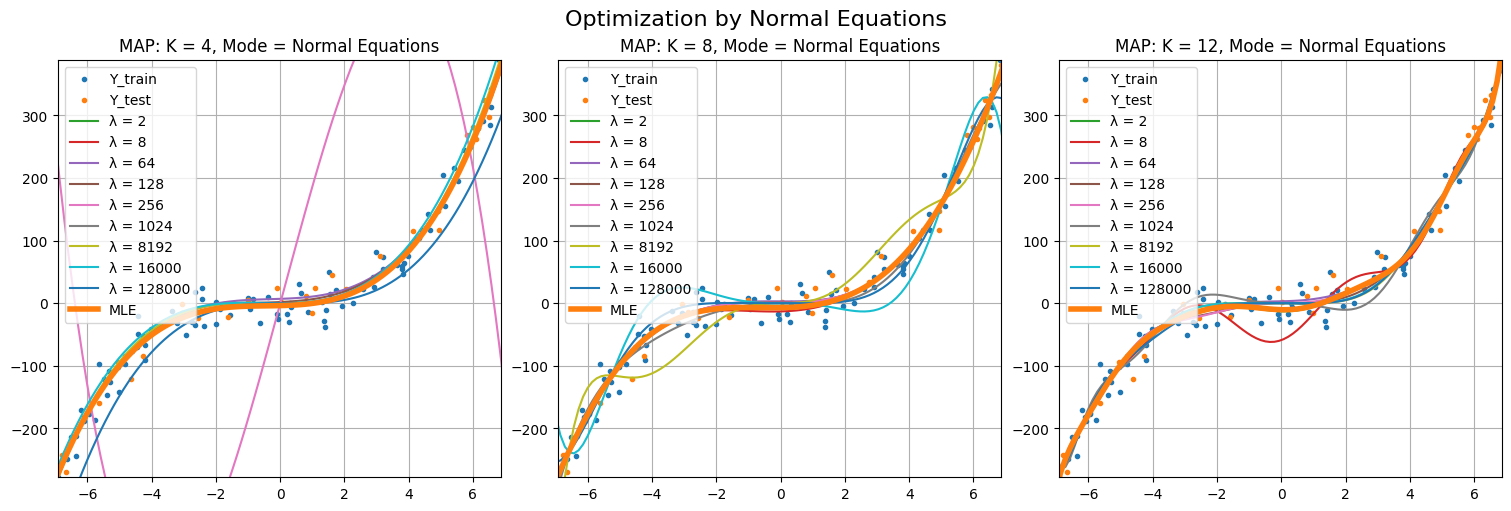

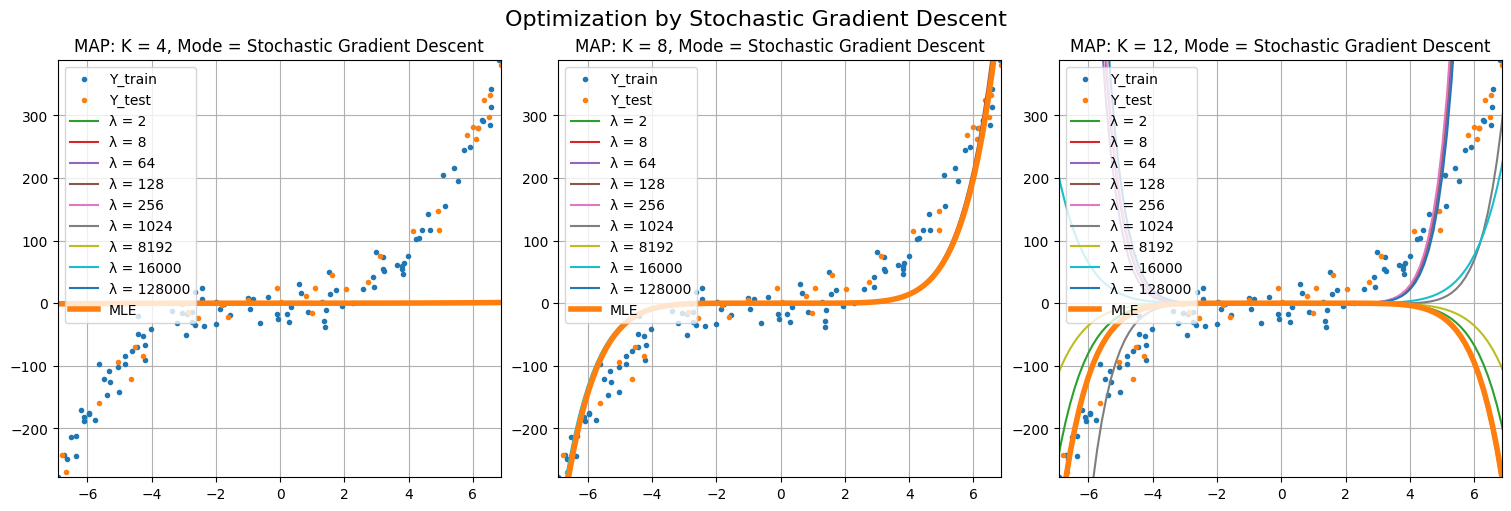

In [963]:
Ks = [4, 8, 12]
lambdas = [2, 8, 64, 128, 256, 1024, 8192, 16000, 128000, 0]

# Determine the overall limits for the plots
all_X = np.concatenate([X_train.flatten(), X_test.flatten()])
all_Y = np.concatenate([Y_train.flatten(), Y_test.flatten()])
x_min, x_max = all_X.min(), all_X.max()
y_min, y_max = all_Y.min(), all_Y.max()

for row, mode_name in enumerate(modes):
    # display(HTML("<center> <h2>Optimization by " + mode_name + "</h2></center>"))
    fig, axes = plt.subplots(nrows=1, ncols=len(Ks), figsize=(15, 5), constrained_layout=True)
    fig.suptitle(f"Optimization by {mode_name}", fontsize=16)
    for col, k in enumerate(Ks):
        ax = axes[col]
        ax.plot(X_train.flatten(), Y_train.flatten(), '.', label='Y_train')
        ax.plot(X_test.flatten(), Y_test.flatten(), '.', label='Y_test')
        
        for lmbda in lambdas:
            theta_NE = MAP((X_train, Y_train), k, lmbda, mode=mode_name)
            regressor = f_theta(np.linspace(a, b, num=100), theta_NE)
            if lmbda == 0:
                ax.plot(np.linspace(a, b, num=100), regressor, linewidth=4.0, label='MLE')
            else:
                ax.plot(np.linspace(a, b, num=100), regressor, label=f'λ = {lmbda}')
        
        ax.set_title(f"MAP: K = {k}, Mode = {mode_name}")
        ax.grid(True)
        ax.legend()
        
        # Set consistent limits for x and y axes
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
    
    plt.show()

## 3.7) For K being way greater than the correct degree of the polynomial, compute the MLE and MAP solution. Compare the test error of the two, for different values of $λ$ (in the case of MAP)

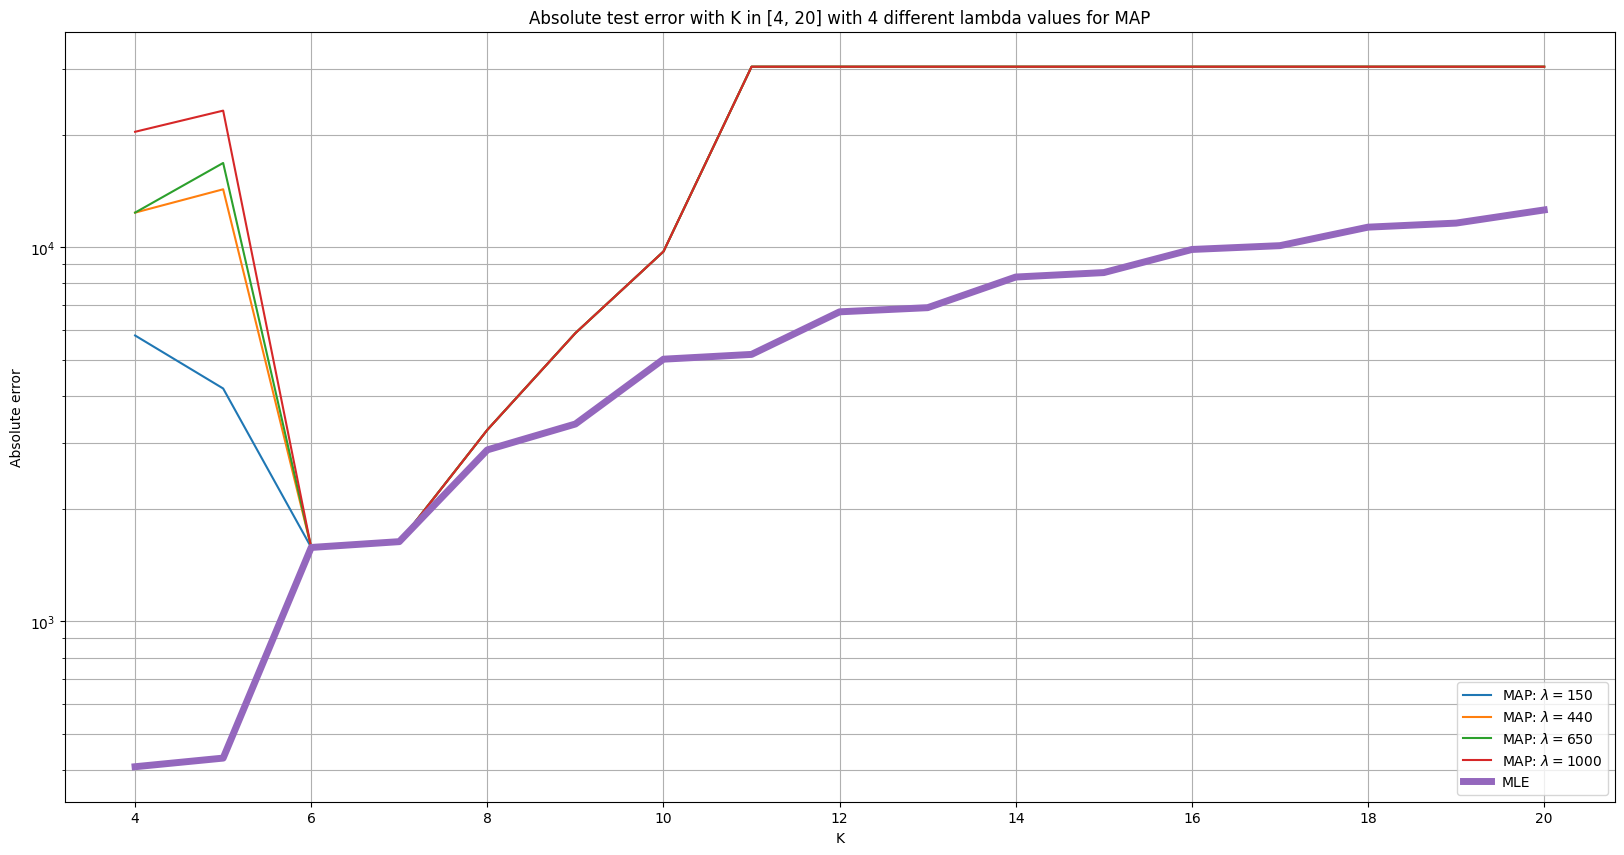

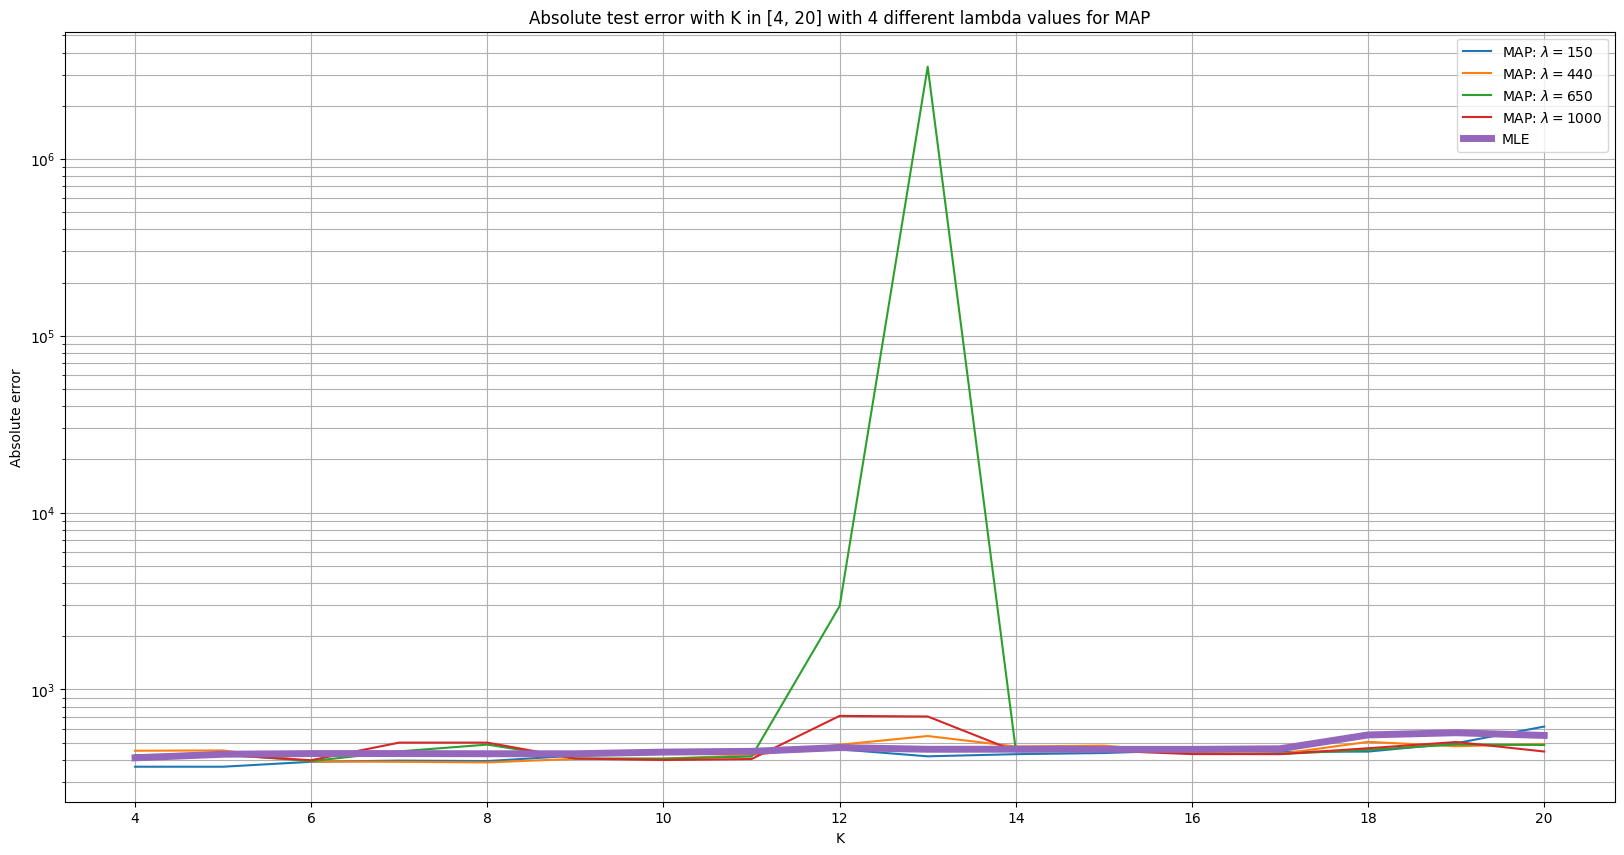

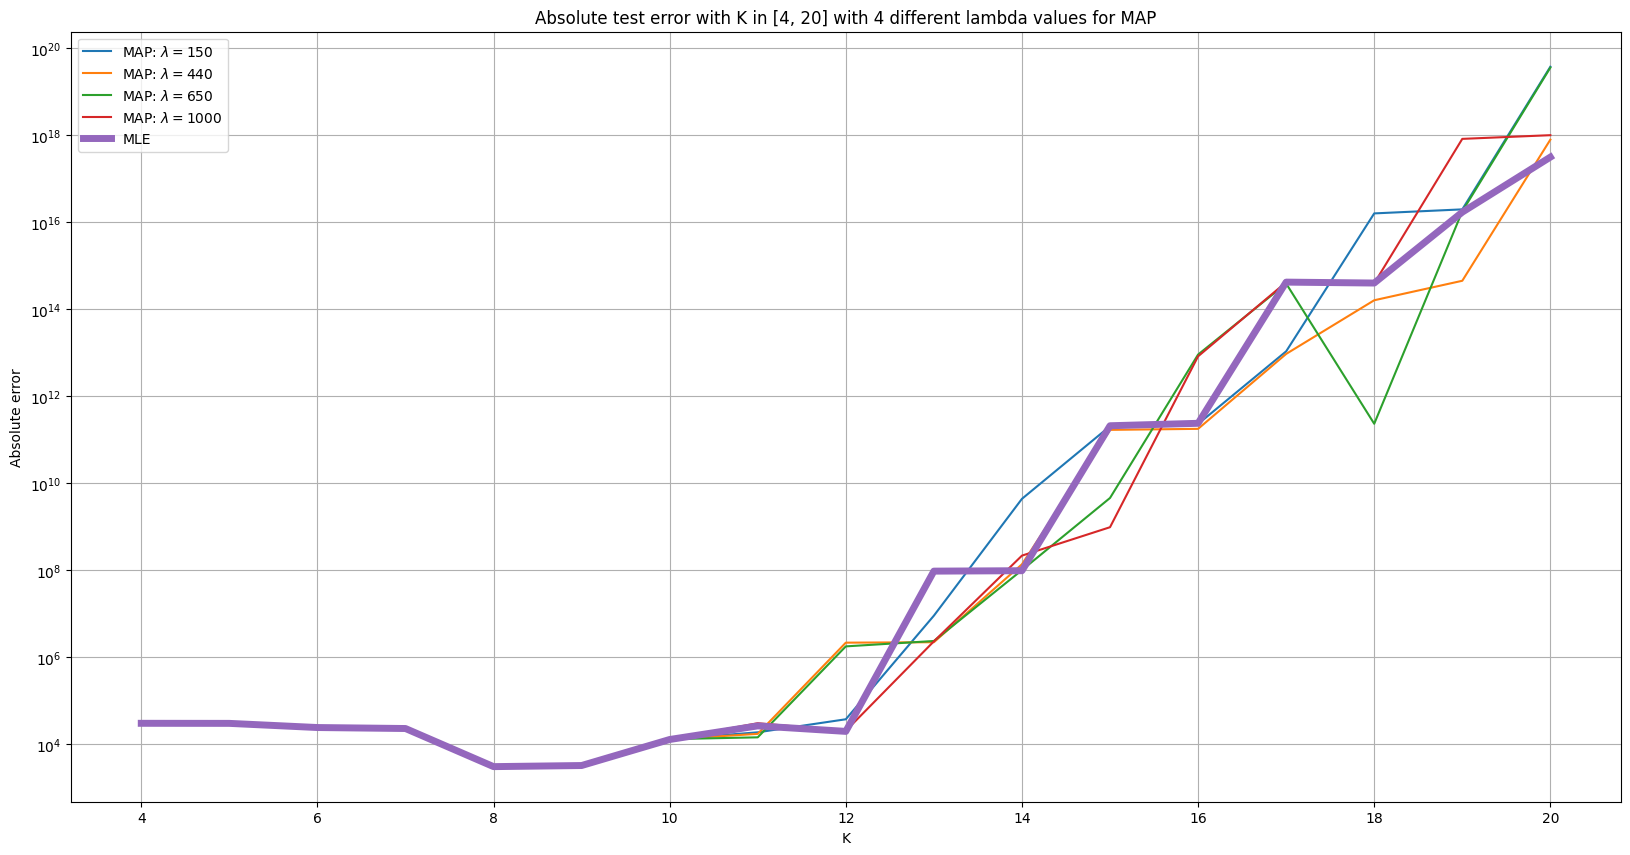

In [966]:
stop = 21
Ks = np.arange(start=4, stop=stop, step=1)
lambdas = [150, 440, 650, 1000]
count = 1
for mode_name in modes:
    display(HTML("<center> <h2>Optimization by " + mode_name + "</h2></center>"))
    
    test_err_MLE = []
    plt.figure(figsize=(20,10))
    
    # MLE
    for k in Ks:
        Phi_k = Vandermonde(X_train, k)
        theta_NE_MLE = MLE((X_train, Y_train), k, mode=mode_name)
        test_err_MLE.append(avg_absolute_error(theta_NE_MLE, (X_test, Y_test)))

    # MAP
    for lmbda in lambdas:
        test_err_MAP = []
        for k in Ks:
            theta_NE_MAP = MAP((X_train, Y_train), k, lmbda, mode=mode_name)
            test_err_MAP.append(avg_absolute_error(theta_NE_MAP, (X_test, Y_test)))
        plt.plot(Ks, test_err_MAP)

    plt.plot(Ks, test_err_MLE, linewidth=5.0)
    plt.grid(True, which='both')
    plt.legend([fr'MAP: $\lambda = {lambdas[0]}$', fr'MAP: $\lambda = {lambdas[1]}$', fr'MAP: $\lambda = {lambdas[2]}$',fr'MAP: $\lambda = {lambdas[3]}$', 'MLE'])
    plt.xlabel('K')
    plt.yscale('log')
    plt.title(f'Absolute test error with K in [{K}, {stop-1}] with 4 different lambda values for MAP')
    plt.ylabel('Absolute error')
    plt.show()

## 3.8) For K greater than the true degree of the polynomial, define $Err(θ) = \frac{\|θ−θ_{true}\|_2} {\|θ_{true} \|_2}$ , where $θ_{true}$ has been padded with zeros to match the shape of $θ$. Compute $Err(θ_{M LE} )$ and $Err(θ_{M AP} )$ for increasing values of $K$ and different values of $λ$.

In [970]:
def relative_error(theta, theta_true):
    # Pad 0 Zeros at the top, 0 at left and 0 at right
    theta_padded = np.pad(theta_true,((0, theta.shape[0] - theta_true.shape[0]),(0,0)), 'constant')
    return np.linalg.norm(theta - theta_padded, 2) / np.linalg.norm(theta_padded, 2)

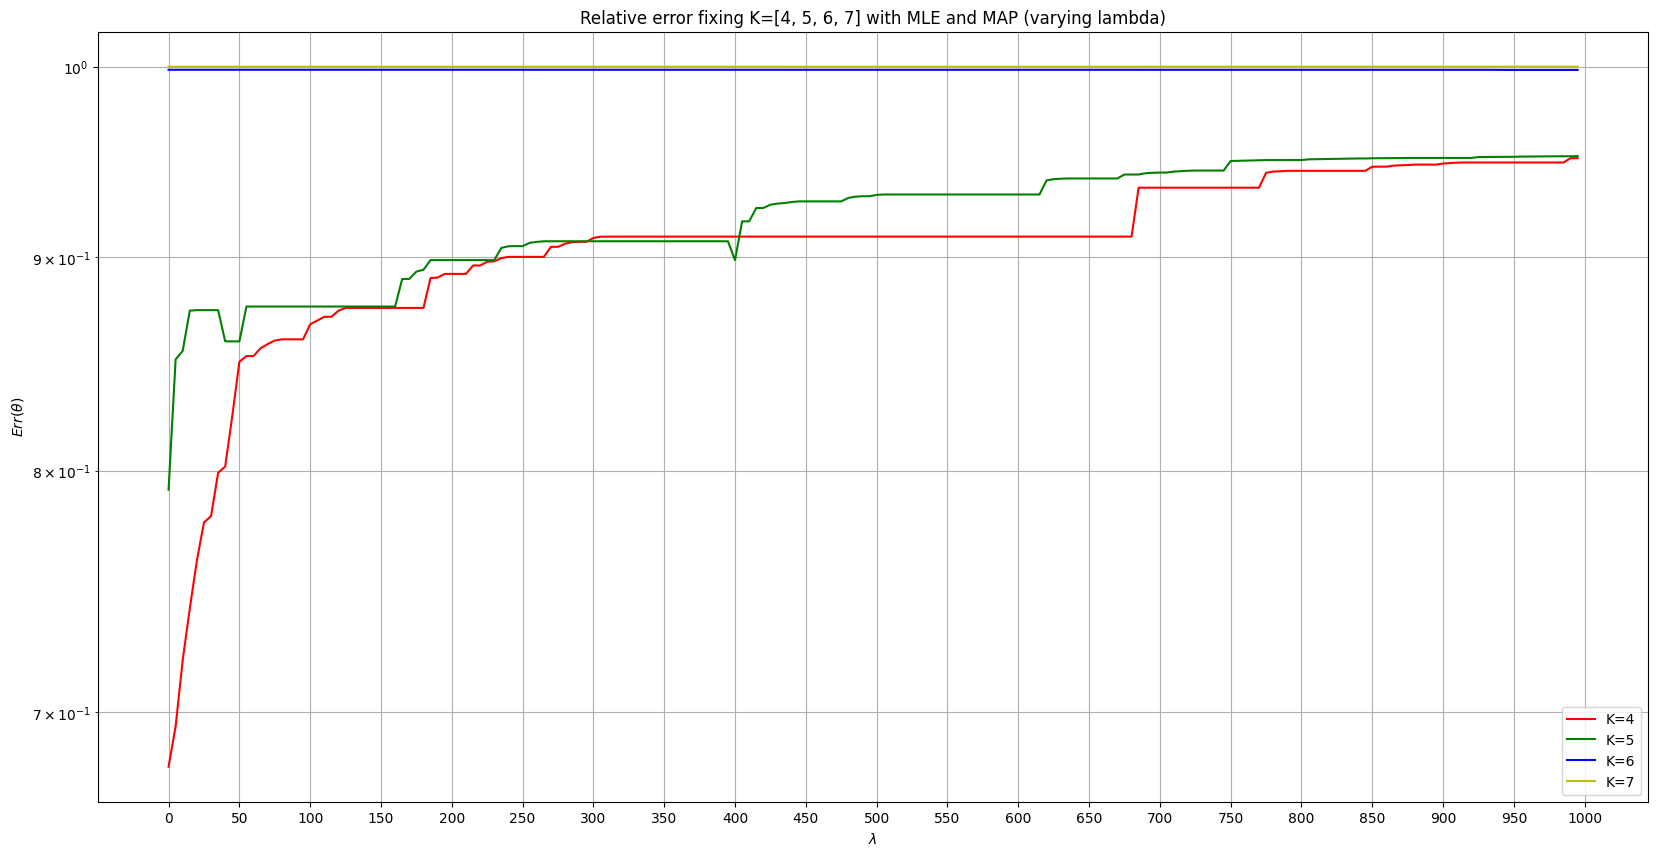

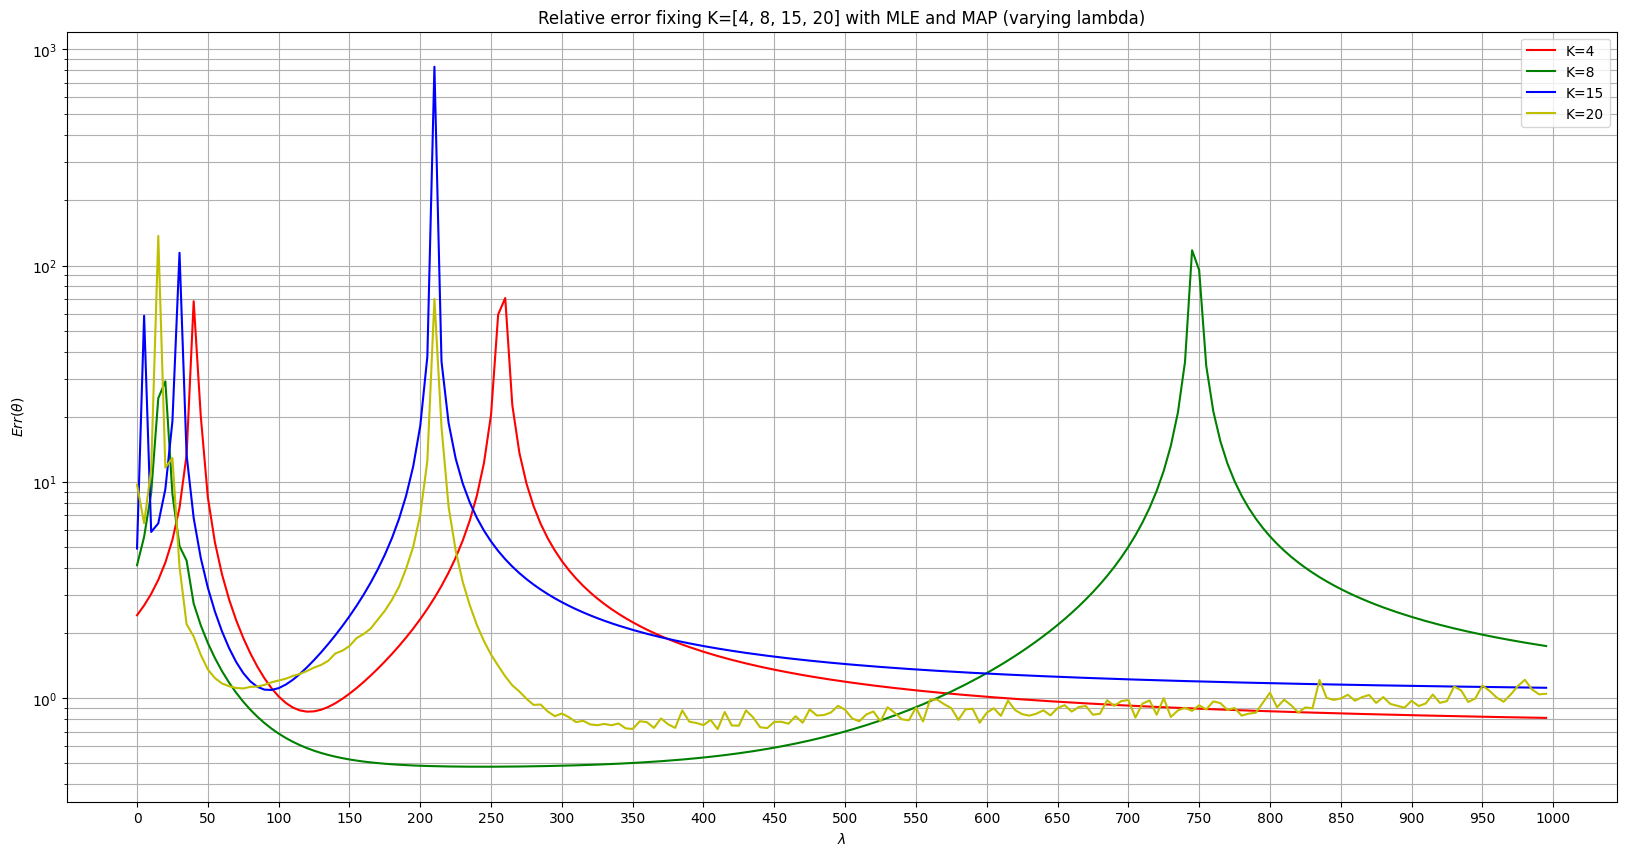

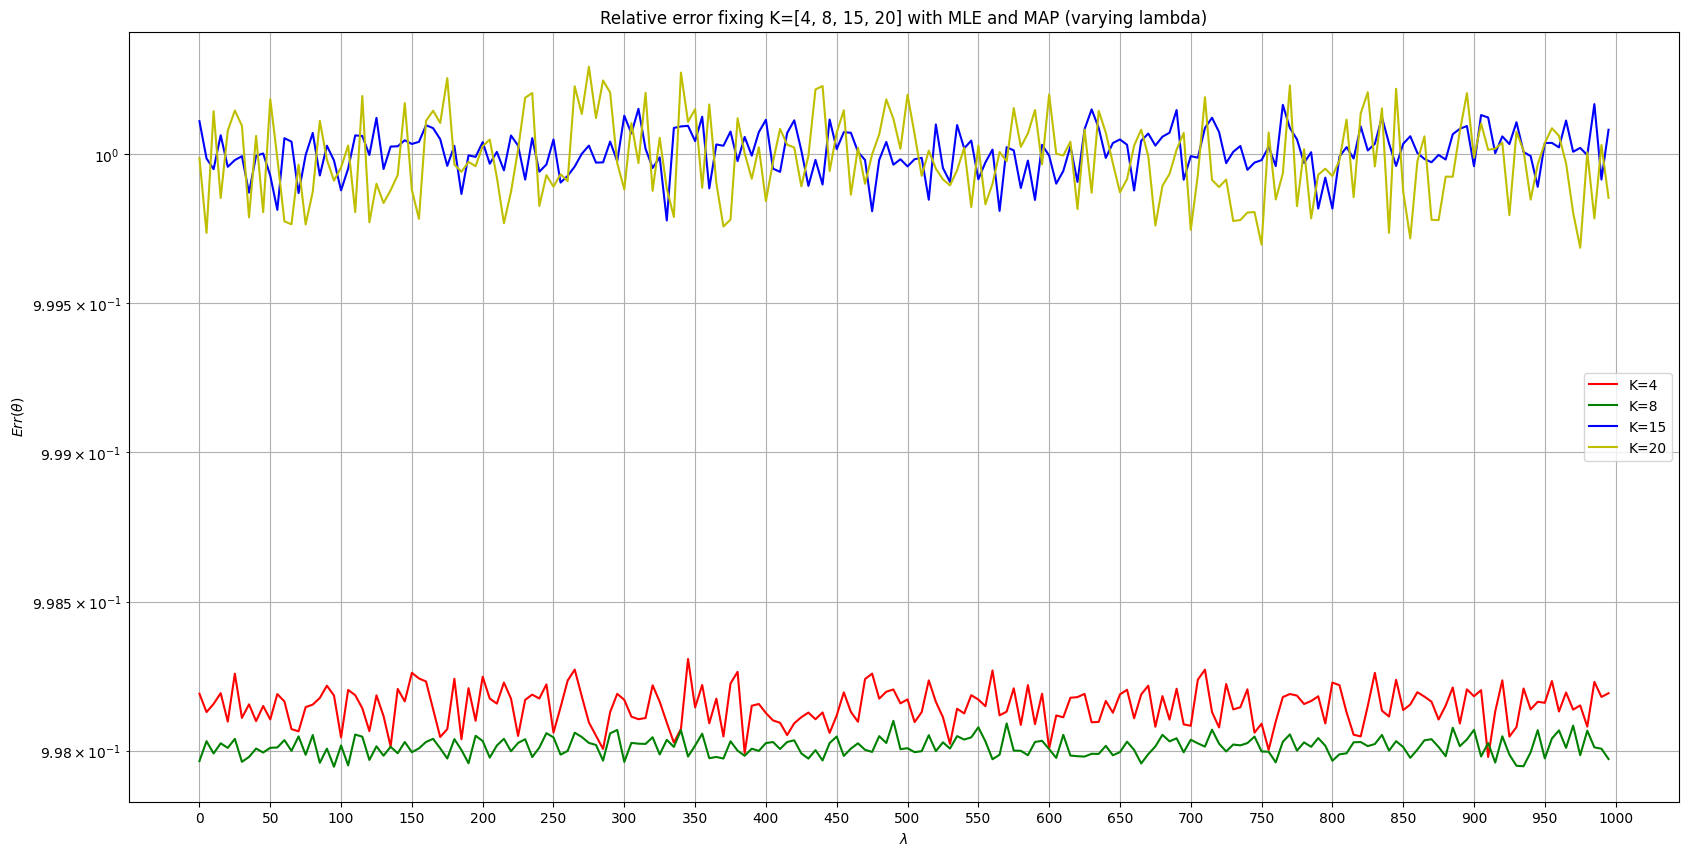

In [977]:
#Plot with k fixed to 4 different values and varying lambda to find a good range
Ks = {
    "Gradient Descent" : [4, 5, 6, 7],
    "Normal Equations" : [4, 8, 15, 20],
    "Stochastic Gradient Descent" : [4, 8, 15, 20]
}
color = ['r', 'g', 'b', 'y', 'c']

for mode_name in modes:
    display(HTML("<center> <h2>Optimization by " + mode_name + "</h2></center>"))
    
    test_err_MAP = []
    lambdas = np.arange(start=0, stop=1000, step=5)

    plt.figure(figsize=(20,10))
    i = 0
    for k in Ks[mode_name]:
        test_err_MAP = []
        theta_NE_MLE = MLE((X_train, Y_train), k, mode=mode_name)
        for lmbda in lambdas:
            theta_NE_MAP = MAP((X_train, Y_train), k, lmbda, mode=mode_name)
            test_err_MAP.append(relative_error(theta_NE_MAP, theta_true))
        plt.plot(lambdas, test_err_MAP, color[i])
        #plt.axhline(y=relative_error(theta_NE_MLE, theta_true), color = color[i], label='_nolegend_')
        plt.grid(True, which='both')
        i += 1
    plt.legend([f'K={Ks[mode_name][0]}',f'K={Ks[mode_name][1]}',f'K={Ks[mode_name][2]}',f'K={Ks[mode_name][3]}'])
    plt.locator_params(axis='x', nbins=25)
    plt.yscale('log')
    plt.title(f'Relative error fixing K={Ks[mode_name]} with MLE and MAP (varying lambda)')
    plt.xlabel(r'$\lambda$')
    plt.ylabel(r'$Err(\theta)$')
    plt.show()


Based on the previous plots, we can observe that we can find goof lambda ranges in :
- Gradient Descent optimization --> [100,700]
- Normal Equations --> [0,700]
- Stochastic Gradient Descent --> [1,1000] (take all the range...)

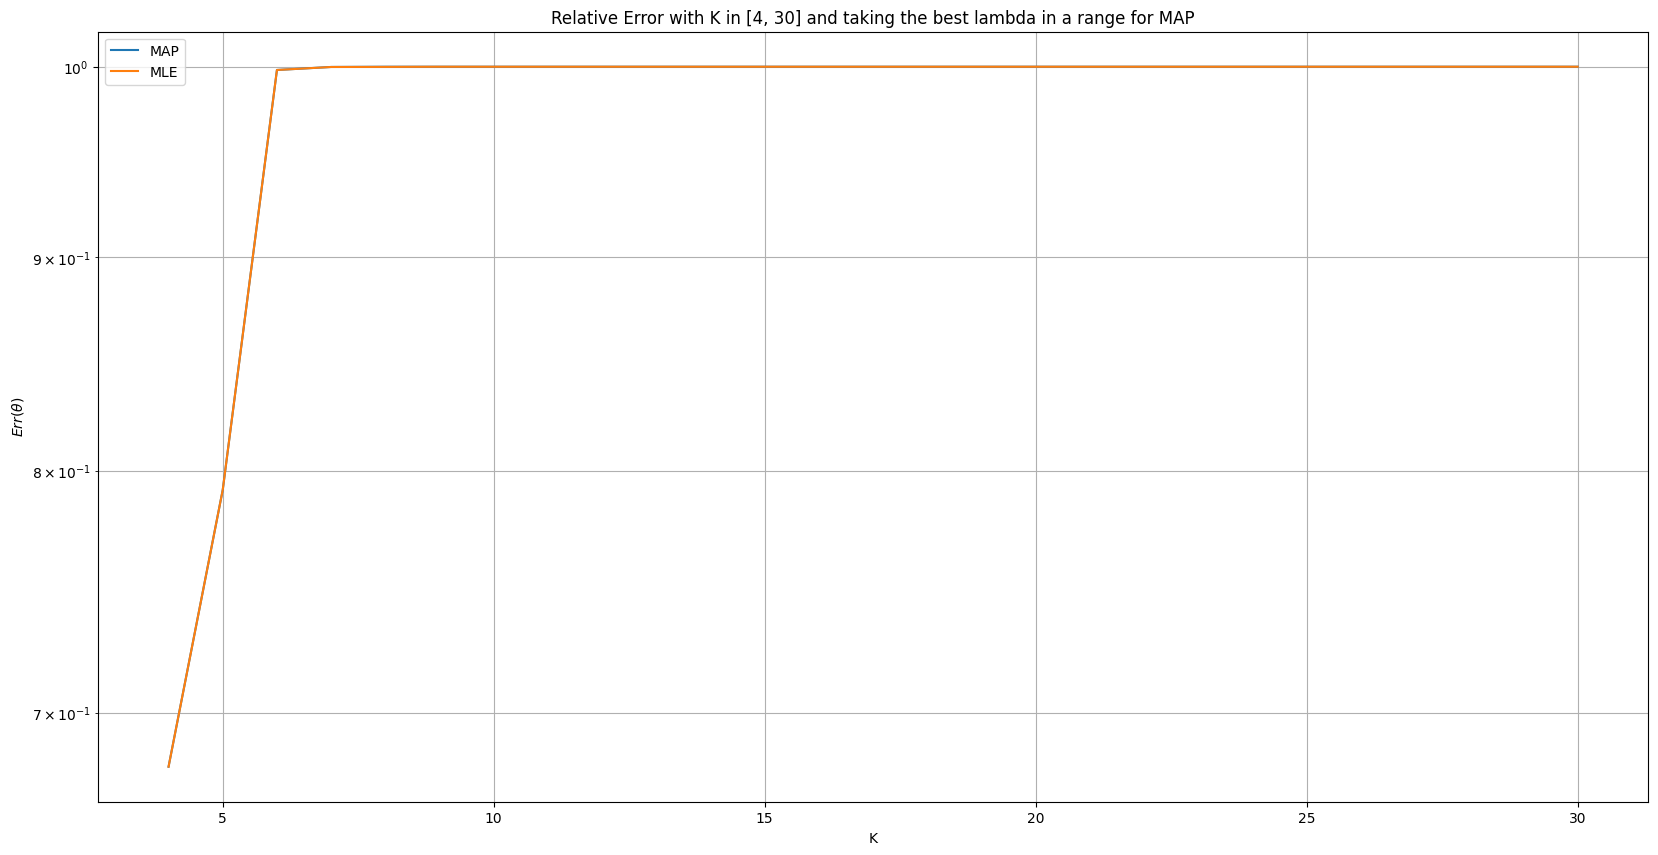

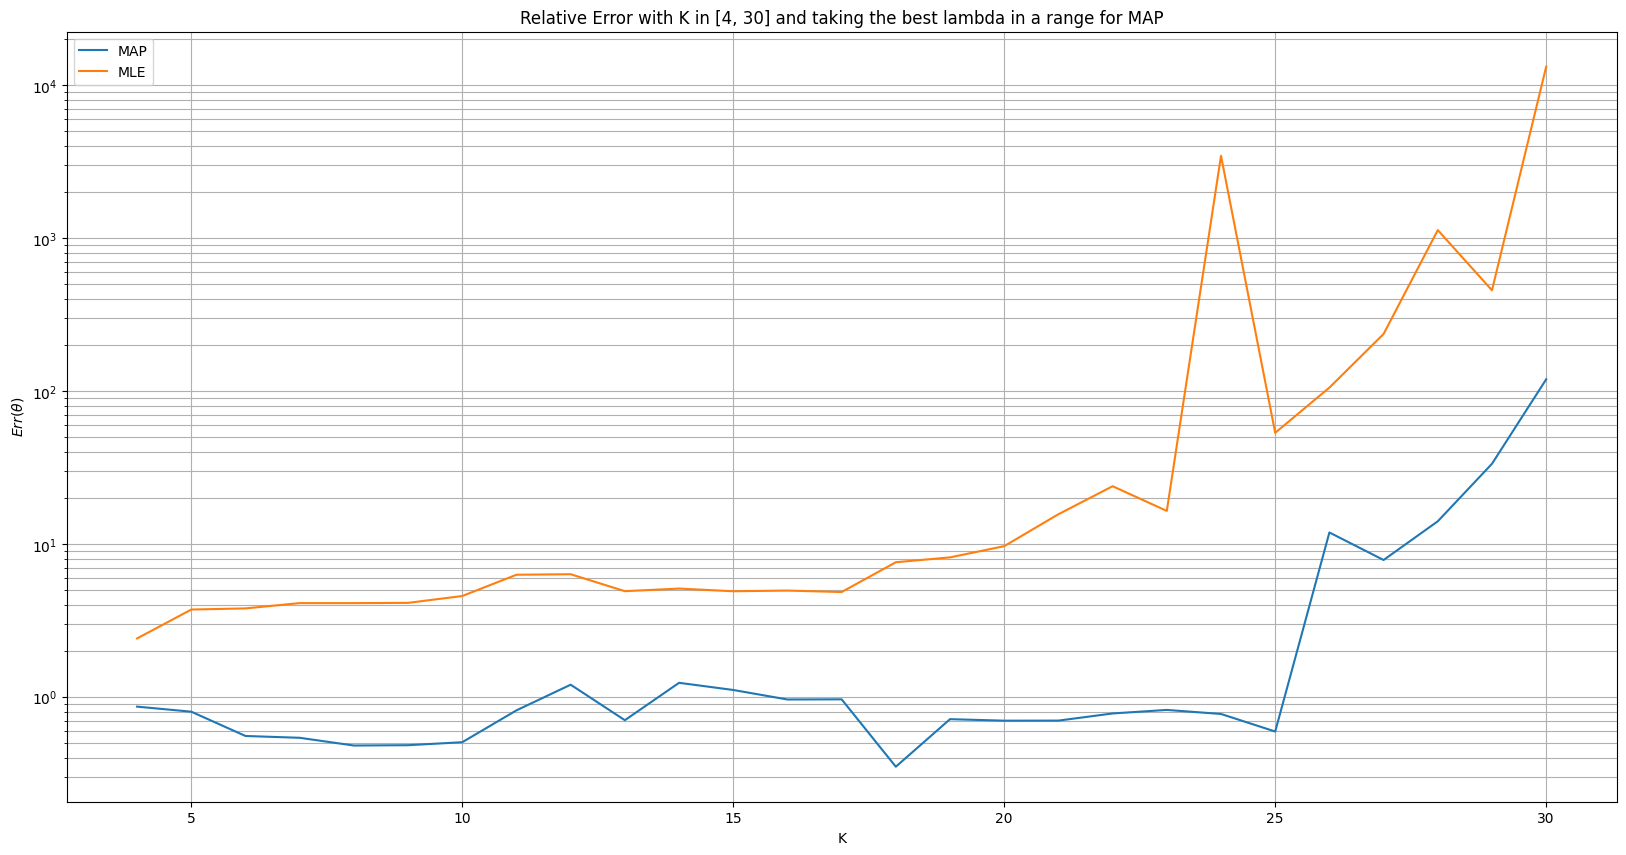

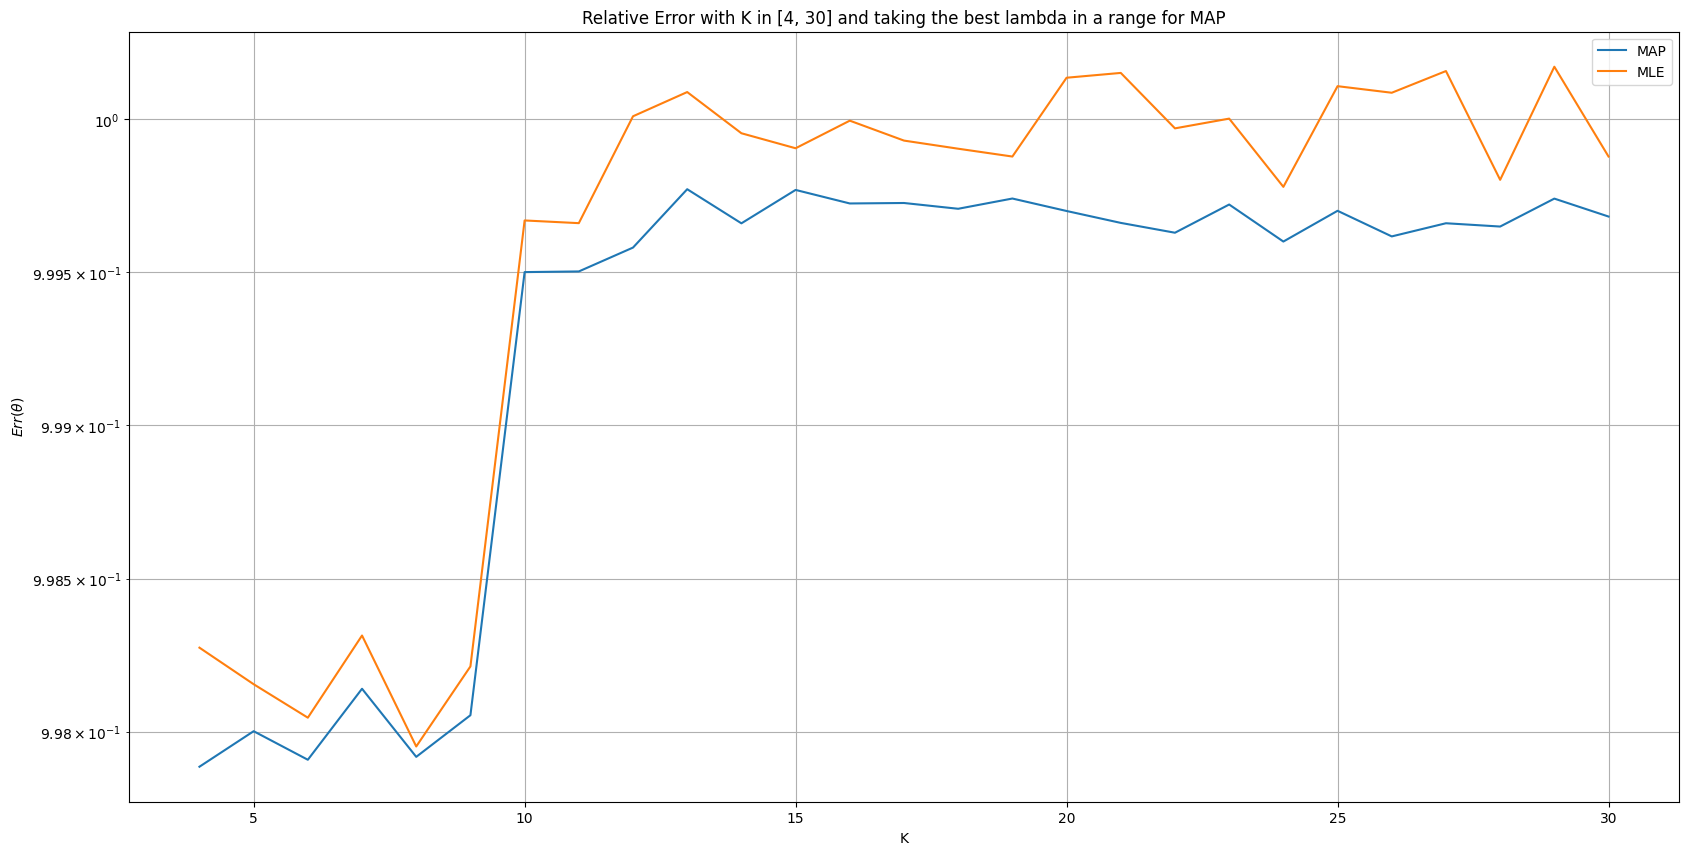

In [982]:
stop = 31
Ks = np.arange(start=K, stop=stop, step=1)
lambdas = {
    "Gradient Descent" : np.arange(start=100, stop=700, step=1),
    "Normal Equations" : np.arange(start=0, stop=700, step=1),
    "Stochastic Gradient Descent" : np.arange(start=0, stop=1000, step=1)
}
    
for mode_name in modes :
    display(HTML("<center> <h2>Optimization by " + mode_name + "</h2></center>"))
    
    test_err_MLE = []
    test_err_MAP = []

    for k in Ks:
        # MLE
        Phi_k = Vandermonde(X_train, k)
        theta_NE_MLE = MLE((X_train, Y_train), k, mode=mode_name)
        test_err_MLE.append(relative_error(theta_NE_MLE, theta_true))

        # MAP using a range of lambdas and choosing the one that makes theta with the smaller relative error
        best_theta = MAP((X_train, Y_train), k, lambdas[mode_name][0], mode=mode_name)
        min_err = relative_error(best_theta, theta_true)
        for lmbda in lambdas[mode_name]:
            theta_NE_MAP = MAP((X_train, Y_train), k, lmbda, mode=mode_name)
            actual_error = relative_error(theta_NE_MAP, theta_true)
            if min_err > actual_error:
                best_theta = theta_NE_MAP
                min_err = actual_error
        test_err_MAP.append(relative_error(best_theta, theta_true))

    plt.figure(figsize=(20,10))
    plt.plot(Ks, test_err_MAP)
    plt.plot(Ks, test_err_MLE)
    plt.grid(True, which='both')
    plt.legend(['MAP', 'MLE'])
    plt.xlabel('K')
    plt.yscale('log')
    plt.title(f'Relative Error with K in [{K}, {stop-1}] and taking the best lambda in a range for MAP')
    plt.ylabel(r'$Err(\theta)$')
    plt.show()

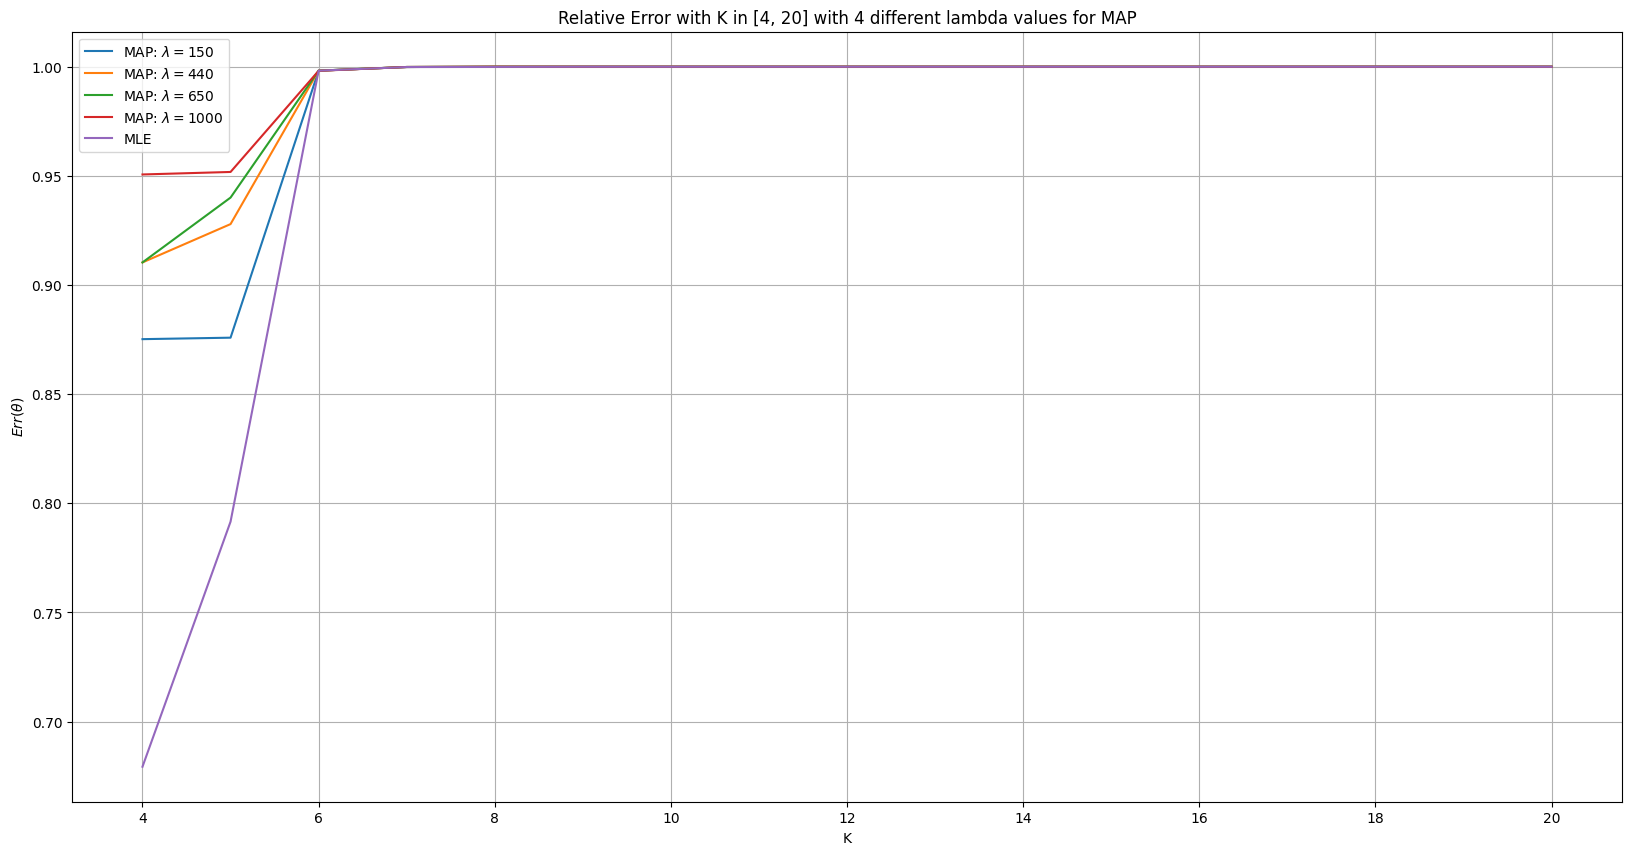

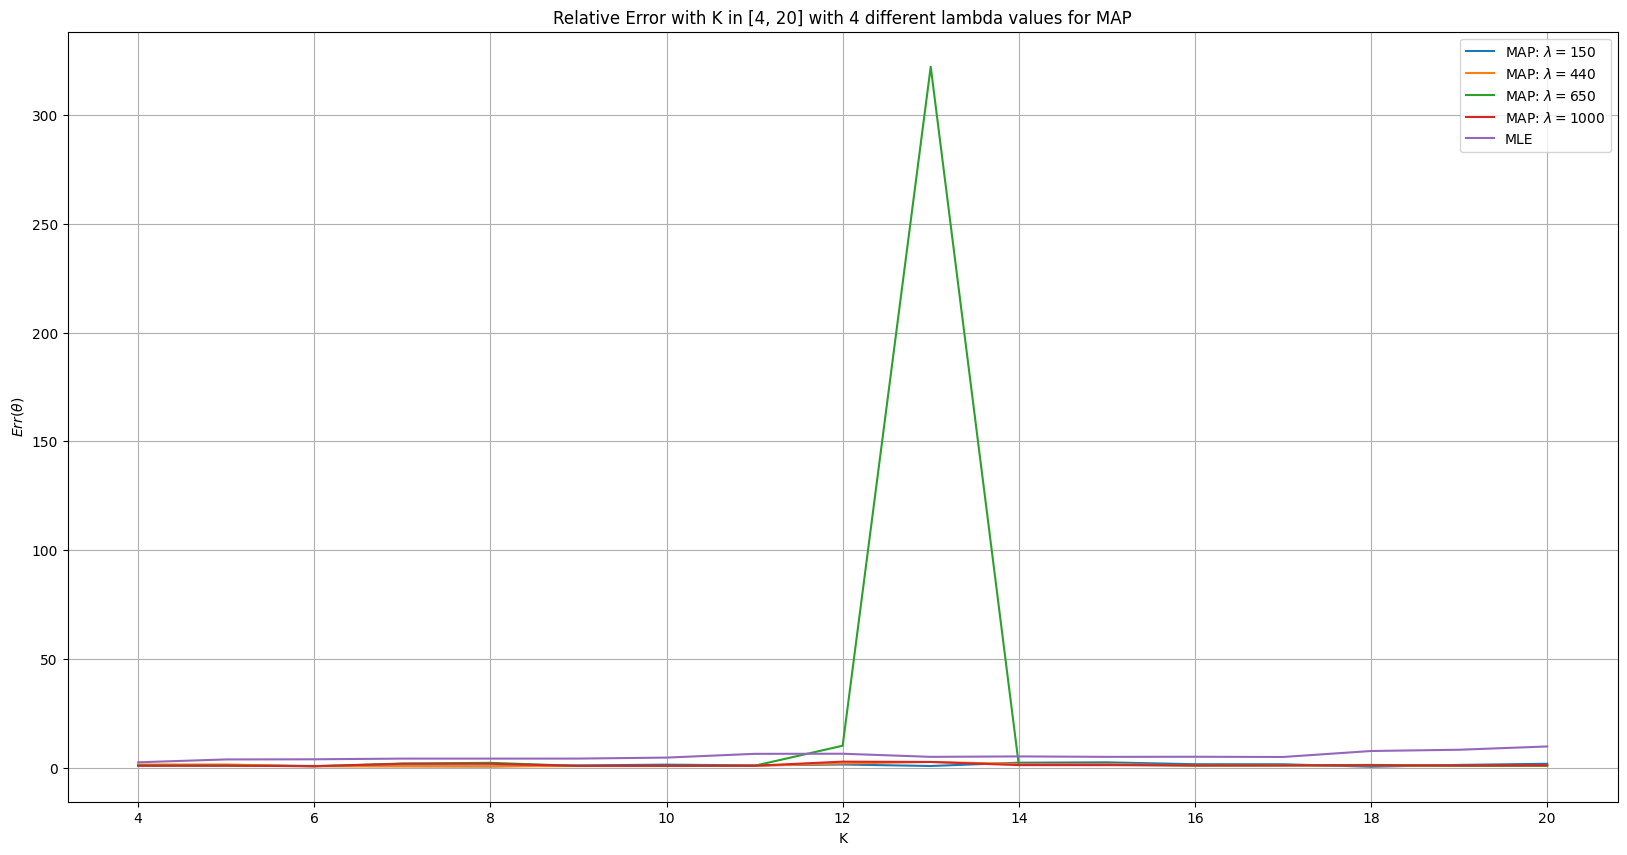

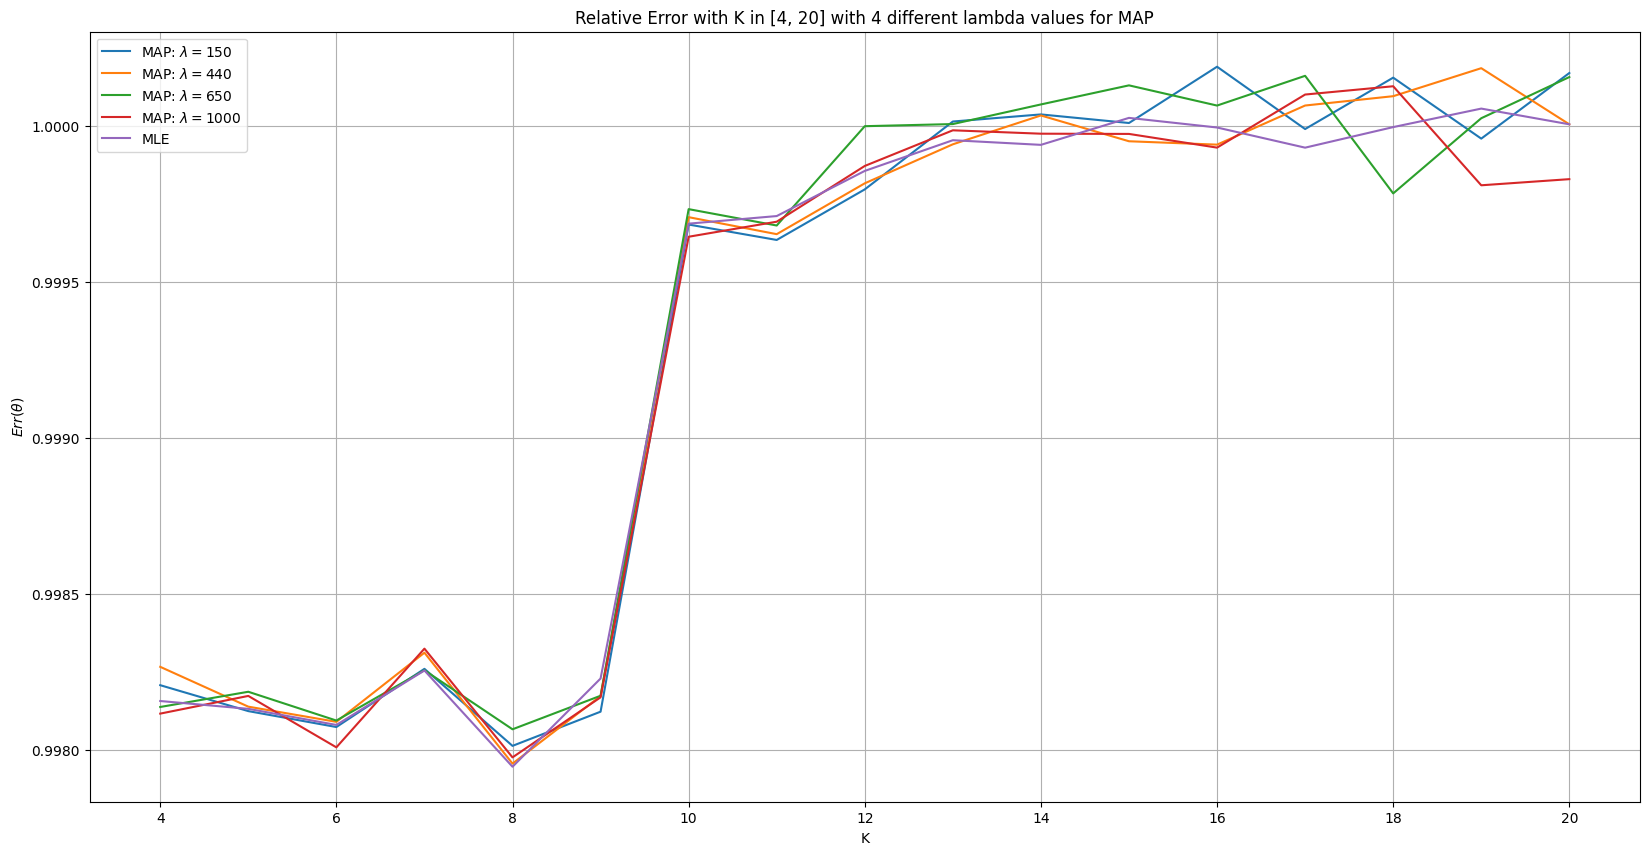

In [984]:
# Now choosing some fixed lambdas
stop = 21
Ks = np.arange(start=K, stop=stop, step=1)
lambdas = [150, 440, 650, 1000]

for mode_name in modes :
    test_err_MLE = []

    plt.figure(figsize=(20,10))
    # MLE
    for k in Ks:
        Phi_k = Vandermonde(X_train, k)
        theta_NE_MLE = MLE((X_train, Y_train), k, mode=mode_name)
        test_err_MLE.append(relative_error(theta_NE_MLE, theta_true))

    # MAP
    for lmbda in lambdas:
        test_err_MAP = []
        for k in Ks:
            theta_NE_MAP = MAP((X_train, Y_train), k, lmbda, mode=mode_name)
            test_err_MAP.append(relative_error(theta_NE_MAP, theta_true))
        plt.plot(Ks, test_err_MAP)

    plt.plot(Ks, test_err_MLE)
    plt.grid(True, which='both')
    plt.legend([fr'MAP: $\lambda = {lambdas[0]}$', fr'MAP: $\lambda = {lambdas[1]}$', fr'MAP: $\lambda = {lambdas[2]}$',fr'MAP: $\lambda = {lambdas[3]}$', 'MLE'])
    plt.xlabel('K')
    plt.title(f'Relative Error with K in [{K}, {stop-1}] with 4 different lambda values for MAP')
    plt.ylabel(r'$Err(\theta)$')
    plt.show()